In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from google.cloud import bigquery;
from google.cloud.bigquery import dbapi;
%load_ext google.cloud.bigquery
from google.cloud import bigquery
from pdf2image import convert_from_path
from IPython.display import Image, display
# client=bigquery.Client()
client = bigquery.Client("som-nero-phi-jonc101")

/Users/wenyuanchen/anaconda3/lib/python3.11/site-packages/google/cloud/bigquery/__init__.py:237: FutureWarning: %load_ext google.cloud.bigquery is deprecated. Install bigquery-magics package and use `%load_ext bigquery_magics`, instead.
  warnings.warn(
/Users/wenyuanchen/anaconda3/lib/python3.11/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [1]:
def find_unique_orders(df, return_combinations=False,):
    """
    Find the number of unique combinations of specific columns in a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        return_combinations (bool): If True, return the unique combinations as a DataFrame.
                                   If False, return only the count of unique combinations.

    Returns:
        int or pd.DataFrame: The number of unique combinations or a DataFrame of unique combinations.
    """
    # Drop duplicates based on the specified columns
    subset = ['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc']
    unique_combinations = df.drop_duplicates(subset=subset)
    
    # Count the number of unique combinations
    num_unique_combinations = len(unique_combinations)
    
    # Return the result based on the return_combinations flag
    if return_combinations:
        return unique_combinations
    else:
        return num_unique_combinations

In [4]:
# clean_antibiotic.csv is downloaded from the following URL: https://docs.google.com/spreadsheets/d/1NUBXLbMZ4n3A0-b-waVQGTOmcFSi0rSp/edit?gid=1568991887#gid=1568991887 
clean_antibiotic = pd.read_csv("../csv_folder/clean_antibiotic.csv") # the top 50 is the same as prior_antibiotics_list in bigquery
antibiotic_list = clean_antibiotic["antibiotic_name"]

In [13]:
# Define a function to find antibiotic matches in the medication name
def find_antibiotics(med_name, antibiotic_list = antibiotic_list):
    if pd.isna(med_name):
        return None
    matches = [j for j in antibiotic_list if j.lower() in med_name.lower()]
    return matches if matches else "No Match"


In [87]:
cleaning_mapping = {
    # Original: Cleaned
    'Ceftriaxone': 'Ceftriaxone',
    'Sulfamethoxazole-Trimethoprim': 'Trimethoprim/Sulfamethoxazole',
    'Ciprofloxacin': 'Ciprofloxacin',
    'Ertapenem': 'Ertapenem',
    'Piperacillin-Tazobactam-Dextrs': 'Piperacillin/Tazobactam',
    'Piperacillin-Tazobactam': 'Piperacillin/Tazobactam',
    'Azithromycin': 'Azithromycin',
    'Doxycycline Hyclate': 'Doxycycline',
    'Ciprofloxacin In': 'Ciprofloxacin',
    'Vancomycin': 'Vancomycin',
    'Ciprofloxacin Hcl': 'Ciprofloxacin',
    'Cephalexin': 'Cephalexin/Cephalothin',
    'Cefazolin In Dextrose': 'Cefazolin',
    'Metronidazole In Nacl': 'Metronidazole',
    'Vancomycin In': 'Vancomycin',
    'Nitrofurantoin': 'Nitrofurantoin',
    'Metronidazole': 'Metronidazole',
    'Moxifloxacin': 'Moxifloxacin',
    'Cefepime': 'Cefepime',
    'Levofloxacin In': 'Levofloxacin',
    'Amoxicillin-Pot Clavulanate': 'Amoxicillin/Clavulanic Acid',
    'Ceftazidime-Dextrose': 'Ceftazidime',
    'Levofloxacin': 'Levofloxacin',
    'Rifaximin': 'Rifaximin',
    'Cefazolin': 'Cefazolin',
    'Cefpodoxime': 'Cefpodoxime',
    'Clindamycin In': 'Clindamycin',
    'Gentamicin': 'Gentamicin',
    'Rifampin': 'Rifampin',
    'Aztreonam': 'Aztreonam',
    'Meropenem': 'Meropenem',
    'Amoxicillin': 'Amoxicillin',
    'Linezolid': 'Linezolid',
    'Ampicillin': 'Ampicillin',
    'Cefdinir': 'Cefdinir',
    'Gentamicin-Sodium Citrate': 'Gentamicin',
    'Ethambutol': 'Ethambutol',
    'Rifabutin': 'Rifabutin',
    'Penicillin': 'Penicillin',
    'Cefoxitin': 'Cefoxitin',
    'Vancomycin In Dextrose': 'Vancomycin',
    'Clarithromycin': 'Clarithromycin',
    'Fidaxomicin': 'Fidaxomicin',
    'Trimethoprim': 'Trimethoprim',
    'Erythromycin': 'Erythromycin',
    'Isoniazid': 'Isoniazid',
    'Clindamycin Hcl': 'Clindamycin',
    'Aztreonam In': 'Aztreonam',
    'Ceftazidime': 'Ceftazidime',
    'Nitrofurantoin Macrocrystal': 'Nitrofurantoin',
    'Fosfomycin Tromethamine': 'Fosfomycin',
    'Erythromycin Ethylsuccinate': 'Erythromycin Ethylsuccinate',
    'Minocycline': 'Minocycline',
    'Ciprofloxacin-Dexamethasone': 'Ciprofloxacin',
    'Ofloxacin': 'Ofloxacin',
    'Silver Sulfadiazine': 'Silver Sulfadiazine',
    'Dicloxacillin': 'Dicloxacillin',
    'Clindamycin Phosphate': 'Clindamycin',
    'Tobramycin Sulfate': 'Tobramycin',
    'Tobramycin-Dexamethasone': 'Tobramycin',
    'Cefuroxime Axetil': 'Cefuroxime Axetil',
    'Dapsone': 'Dapsone',
    'Methenamine Hippurate': 'Methenamine',
    'Colistin': 'Colistin',
    'Cefadroxil': 'Cefadroxil',
    'Amikacin': 'Amikacin',
    'Gatifloxacin': 'Gatifloxacin',
    'Gentamicin In Nacl': 'Gentamicin'
}

In [130]:
%%bigquery --use_rest_api all_urine_peds_cohort
-- Step 1: Extract microbiology cultures for specific types (URINE)
WITH microbiology_cultures AS (
    SELECT DISTINCT
        op.anon_id, 
        op.pat_enc_csn_id_coded, 
        op.order_proc_id_coded, 
        op.order_time_jittered_utc, 
        op.ordering_mode,
        lr.result_time_jittered_utc, # added the result time too
        CASE 
            WHEN op.description LIKE '%URINE%' THEN 'URINE'
            ELSE 'OTHER' 
        END AS culture_description  -- Capture the culture type
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
    ON
        op.order_proc_id_coded = lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND (op.description LIKE "%URINE%")
), # Only keep urine culture


######################################################################################## 
-- Step 2: Filter for adult patients only
########################################################################################    

adult_microbiology_cultures AS (
    SELECT 
        mc.anon_id, 
        mc.pat_enc_csn_id_coded, 
        mc.order_proc_id_coded, 
        mc.order_time_jittered_utc, 
        mc.ordering_mode,
        mc.culture_description, -- Include culture_description here
        mc.result_time_jittered_utc

    FROM 
        microbiology_cultures mc
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.demographic` demo
    USING
        (anon_id)
    WHERE
        DATE_DIFF(CAST(mc.order_time_jittered_utc as DATE), demo.BIRTH_DATE_JITTERED, YEAR) < 18
)
select * from adult_microbiology_cultures

Query is running:   0%|          |

Downloading:   0%|          |

In [131]:
print("the unique order number for all urine culture is {}".format(find_unique_orders(all_urine_peds_cohort)))

the unique order number for all urine culture is 64772


In [6]:
%%bigquery --use_rest_api peds_starting_cohort
-- This query is the main query for creating a table named microbiology_cultures_cohort that forms the basis of the microbiology cultures cohort. 
-- The table is generated through a series of steps, each designed to filter and enrich the dataset. 
-- Once the main cohort table is created, additional features will be added to this table to complete the dataset for analysis.


######################################################################################## 
-- Create or replace the cohort table named microbiology_urine_cultures_cohort
######################################################################################## 


-- Step 1: Extract microbiology cultures for specific types (URINE)
WITH microbiology_cultures AS (
    SELECT DISTINCT
        op.anon_id, 
        op.pat_enc_csn_id_coded, 
        op.order_proc_id_coded, 
        op.order_time_jittered_utc, 
        op.ordering_mode,
        lr.result_time_jittered_utc, # added the result time too
        CASE 
            WHEN op.description LIKE '%URINE%' THEN 'URINE'
            ELSE 'OTHER' 
        END AS culture_description  -- Capture the culture type
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
    ON
        op.order_proc_id_coded = lr.order_id_coded
    WHERE
        op.order_type LIKE "Microbiology%"
        AND (op.description LIKE "%URINE%")
), # Only keep urine culture


######################################################################################## 
-- Step 2: Filter for adult patients only
########################################################################################    

adult_microbiology_cultures AS (
    SELECT 
        mc.anon_id, 
        mc.pat_enc_csn_id_coded, 
        mc.order_proc_id_coded, 
        mc.order_time_jittered_utc, 
        mc.ordering_mode,
        mc.culture_description, -- Include culture_description here
        mc.result_time_jittered_utc

    FROM 
        microbiology_cultures mc
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.demographic` demo
    USING
        (anon_id)
    WHERE
        DATE_DIFF(CAST(mc.order_time_jittered_utc as DATE), demo.BIRTH_DATE_JITTERED, YEAR) < 18
),

    
######################################################################################## 
-- Step 3: Identify culture orders within the prior two weeks
########################################################################################     
    
order_in_prior_two_weeks AS (
    SELECT DISTINCT
         auc.order_proc_id_coded
    FROM 
        `som-nero-phi-jonc101.shc_core_2023.order_proc` op
    INNER JOIN
        `som-nero-phi-jonc101.shc_core_2023.lab_result` lr
    ON
        op.order_proc_id_coded = lr.order_id_coded
    INNER JOIN
        adult_microbiology_cultures auc 
    ON
        op.anon_id = auc.anon_id
    WHERE
        op.order_type LIKE "Microbiology%"
        AND (op.description LIKE "%URINE%")
        AND auc.order_time_jittered_utc > op.order_time_jittered_utc
        AND TIMESTAMP_DIFF(auc.order_time_jittered_utc, op.order_time_jittered_utc, DAY) < 14
),

    
######################################################################################## 
-- Step 4: Exclude cultures with a prior culture order in the last two weeks
########################################################################################       

included_microbiology_cultures AS (
    SELECT DISTINCT
        amc.*
    FROM 
        adult_microbiology_cultures amc
    WHERE 
        amc.order_proc_id_coded NOT IN (SELECT order_proc_id_coded FROM order_in_prior_two_weeks)
),

###########################################################################################################
-- Step 5: Flag cultures as positive if they have corresponding entries in the culture_sensitivity table
###########################################################################################################    

all_cultures_with_flag AS (
    SELECT 
        imc.anon_id, 
        imc.pat_enc_csn_id_coded, 
        imc.order_proc_id_coded, 
        imc.order_time_jittered_utc, 
        imc.result_time_jittered_utc,
        imc.ordering_mode,
        imc.culture_description,
        IF(cs.order_proc_id_coded IS NOT NULL, 1, 0) AS was_positive
    FROM 
        included_microbiology_cultures imc
    LEFT JOIN 
        (SELECT DISTINCT order_proc_id_coded FROM `som-nero-phi-jonc101.shc_core_2023.culture_sensitivity`) cs
    ON 
        imc.order_proc_id_coded = cs.order_proc_id_coded
),


#########################################################################################################################
-- Step 6: Get detailed information for positive cultures, clean antibiotic names, and exclude non-antibiotic entries
#########################################################################################################################     
positive_culture_details AS (
    SELECT 
        cs.order_proc_id_coded,
        cs.organism,
        -- Clean and standardize the antibiotic name using the updated cleaning approach
        INITCAP(TRIM(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
            REGEXP_REPLACE(
                REGEXP_REPLACE(
                    LOWER(cs.antibiotic),
                    'penicillin[^a-z].*$', 'penicillin'
                ),
                '^[^a-z]*|\\s+\\S*[^a-z\\s]+.*$|\\.+$', ''
            ),
              '\\s*\\d+(\\.\\d+)?\\s*(mg|mcg|gram|ml|%)', ''  -- Remove dosages or concentrations
          ),
          '\\(.*?\\)', ''  -- Remove text in parentheses
        ),' in.*$|tablet|capsule|intravenous|piggyback|' ||
                            'solution|suspension|oral|sodium|chloride|' ||
                            'injection|citrate|soln|dextrose|iv|' ||
                            'macrocrystals|macrocrystal|axetil|potassium|packet|' ||
                            'monohydrate|ethylsuccinate|powder|mandelate|' ||
                            'hyclate|hcl|hippurate|tromethamine|' ||
                            'million|unit|syrup|chewable|delayed|mphase|' ||
                            'release|benzathine|syringe|dispersible|' ||
                            'sulfate|procaine|blue|hyos|sod*phos|' ||
                            'susp|and|fosamil|extended|succinate|granules|' ||
                            'delay|pot|ext|rel|cyam|salicylate|salicyl|' ||
                            'sodphos|methylene|stearate|synergy', ''                   
        ),
        '\\d|\\sfor\\s*|/ml\\s*|\\sml\\s*|\\-+\\s*|\\,+\\s*',''
        )
        )
      )  AS antibiotic,
        cs.suscept AS susceptibility
    FROM 
        som-nero-phi-jonc101.shc_core_2023.culture_sensitivity cs
    INNER JOIN (
        -- Subquery to get antibiotic counts for those with more than 10 occurrences
        SELECT 
          INITCAP(TRIM(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
            REGEXP_REPLACE(
                REGEXP_REPLACE(
                    LOWER(antibiotic),
                    'penicillin[^a-z].*$', 'penicillin'
                ),
                '^[^a-z]*|\\s+\\S*[^a-z\\s]+.*$|\\.+$', ''
            ),
              '\\s*\\d+(\\.\\d+)?\\s*(mg|mcg|gram|ml|%)', ''  -- Remove dosages or concentrations
          ),
          '\\(.*?\\)', ''  -- Remove text in parentheses
        ),' in.*$|tablet|capsule|intravenous|piggyback|' ||
                            'solution|suspension|oral|sodium|chloride|' ||
                            'injection|citrate|soln|dextrose|iv|' ||
                            'macrocrystals|macrocrystal|axetil|potassium|packet|' ||
                            'monohydrate|ethylsuccinate|powder|mandelate|' ||
                            'hyclate|hcl|hippurate|tromethamine|' ||
                            'million|unit|syrup|chewable|delayed|mphase|' ||
                            'release|benzathine|syringe|dispersible|' ||
                            'sulfate|procaine|blue|hyos|sod*phos|' ||
                            'susp|and|fosamil|extended|succinate|granules|' ||
                            'delay|pot|ext|rel|cyam|salicylate|salicyl|' ||
                            'sodphos|methylene|stearate|synergy', ''                   
        ),
        '\\d|\\sfor\\s*|/ml\\s*|\\sml\\s*|\\-+\\s*|\\,+\\s*',''
        )
        )
      )AS cleaned_antibiotic,
            COUNT(*) AS count
        FROM 
            som-nero-phi-jonc101.shc_core_2023.culture_sensitivity
        GROUP BY 
            cleaned_antibiotic
        HAVING 
            COUNT(*) >= 10  -- Include only antibiotics that appear 10 times or more
    ) AS antibiotic_counts 
    ON 


      INITCAP(TRIM(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
          REGEXP_REPLACE(
            REGEXP_REPLACE(
                REGEXP_REPLACE(
                    LOWER(cs.antibiotic),
                    'penicillin[^a-z].*$', 'penicillin'
                ),
                '^[^a-z]*|\\s+\\S*[^a-z\\s]+.*$|\\.+$', ''
            ),
              '\\s*\\d+(\\.\\d+)?\\s*(mg|mcg|gram|ml|%)', ''  -- Remove dosages or concentrations
          ),
          '\\(.*?\\)', ''  -- Remove text in parentheses
        ),' in.*$|tablet|capsule|intravenous|piggyback|' ||
                            'solution|suspension|oral|sodium|chloride|' ||
                            'injection|citrate|soln|dextrose|iv|' ||
                            'macrocrystals|macrocrystal|axetil|potassium|packet|' ||
                            'monohydrate|ethylsuccinate|powder|mandelate|' ||
                            'hyclate|hcl|hippurate|tromethamine|' ||
                            'million|unit|syrup|chewable|delayed|mphase|' ||
                            'release|benzathine|syringe|dispersible|' ||
                            'sulfate|procaine|blue|hyos|sod*phos|' ||
                            'susp|and|fosamil|extended|succinate|granules|' ||
                            'delay|pot|ext|rel|cyam|salicylate|salicyl|' ||
                            'sodphos|methylene|stearate|synergy', ''                   
        ),
        '\\d|\\sfor\\s*|/ml\\s*|\\sml\\s*|\\-+\\s*|\\,+\\s*',''
        )
        )
      )= antibiotic_counts.cleaned_antibiotic
    WHERE
        NOT (
            cs.antibiotic LIKE '%InBasket%'  
            OR cs.antibiotic LIKE '%Beta Lactamase%'  
            OR cs.antibiotic LIKE '%BlaZ PCR%'  
            OR cs.antibiotic LIKE '%Carbapenemase%'  
            OR cs.antibiotic LIKE '%D-Test%'  
            OR cs.antibiotic LIKE '%Esbl%'  
            OR cs.antibiotic LIKE '%ermPCR%'  
            OR cs.antibiotic LIKE '%Mupirocin%'  
            OR cs.antibiotic LIKE '%IMP%'  
            OR cs.antibiotic LIKE '%Inducible Clindamycin%'  
            OR cs.antibiotic LIKE '%INTERNAL CONTROL%'  
            OR cs.antibiotic LIKE '%KPC%'  
            OR cs.antibiotic LIKE '%MecA PCR%'  
            OR cs.antibiotic LIKE '%NDM%'  
            OR cs.antibiotic LIKE '%Ox Plate Screen%'  
            OR cs.antibiotic LIKE '%OXA-48-LIKE%'  
            OR cs.antibiotic LIKE '%VIM%'  
            OR cs.antibiotic LIKE '%Method%'  
            OR cs.antibiotic LIKE '%INH%'   
            OR cs.antibiotic LIKE '%Polymyxin B%' 
            OR cs.antibiotic LIKE '%Nalidixic%'   
            OR cs.antibiotic LIKE '%Flucytosine%' 
            OR cs.antibiotic LIKE '%Rifampin%' 
            OR cs.antibiotic LIKE '%Ethambutol%' 
            OR cs.antibiotic LIKE '%Pyrazinamide%' 
            OR cs.antibiotic LIKE '%Clofazimine%' 
            OR cs.antibiotic LIKE '%Rifabutin%' 
            OR cs.antibiotic IN ('Posaconazole','Penicillin/Ampicillin','Omadacycline', 'Amphotericin B', 'Polymixin B', 'Fluconazole', 'Itraconazole', 'Caspofungin', 'Voriconazole', 'Anidulafungin', 'Micafungin', 'Isavuconazole', 'Antibiotic', 'OXA48-LIKE PCR', 'ESBL confirmation test', 'Oxacillin Screen')
        )
)

#########################################################################################################################
  -- Step 7: Final selection of required fields
#########################################################################################################################   

SELECT 
    acwf.anon_id,
    acwf.pat_enc_csn_id_coded,
    acwf.order_proc_id_coded,
    acwf.order_time_jittered_utc,
    acwf.result_time_jittered_utc,
    acwf.ordering_mode,
    acwf.culture_description,
    acwf.was_positive,
    pcd.organism,
    pcd.antibiotic,
    CASE
        WHEN pcd.susceptibility IS NULL THEN NULL  -- Keep NULL values unchanged
        WHEN pcd.susceptibility IN ('Susceptible', 'Not Detected', 'Negative' ) THEN 'Susceptible'
        WHEN pcd.susceptibility IN ('Resistant', 'Non Susceptible', 'Positive', 'Detected') THEN 'Resistant'
        WHEN pcd.susceptibility IN ('Intermediate', 'Susceptible - Dose Dependent') THEN 'Intermediate'
        WHEN pcd.susceptibility IN ('No Interpretation', 'Not done', 'Inconclusive', 'See Comment') THEN 'Inconclusive'
        WHEN pcd.susceptibility IN ('Synergy', 'No Synergy') THEN 'Synergism'
        ELSE 'Unknown'  -- Mark unexpected values as Unknown
    END AS susceptibility
FROM
    all_cultures_with_flag acwf
LEFT JOIN
    positive_culture_details pcd
ON
    acwf.order_proc_id_coded = pcd.order_proc_id_coded
WHERE
    -- Exclude rows where susceptibility would be 'Unknown'
    (pcd.susceptibility IS NULL OR
    pcd.susceptibility IN ('Susceptible', 'Positive', 'Detected',
                           'Resistant', 'Non Susceptible', 'Negative',
                           'Intermediate', 'Susceptible - Dose Dependent',
                           'No Interpretation', 'Not done', 'Inconclusive', 'See Comment',
                           'Synergy', 'No Synergy', 'Not Detected'));


Query is running:   0%|          |

Downloading:   0%|          |

In [7]:
print("the unique order number for urine only starting culture after 2 week exclusion is {}".format(find_unique_orders(peds_starting_cohort)))

the unique order number for urine only starting culture after 2 week exclusion is 58118


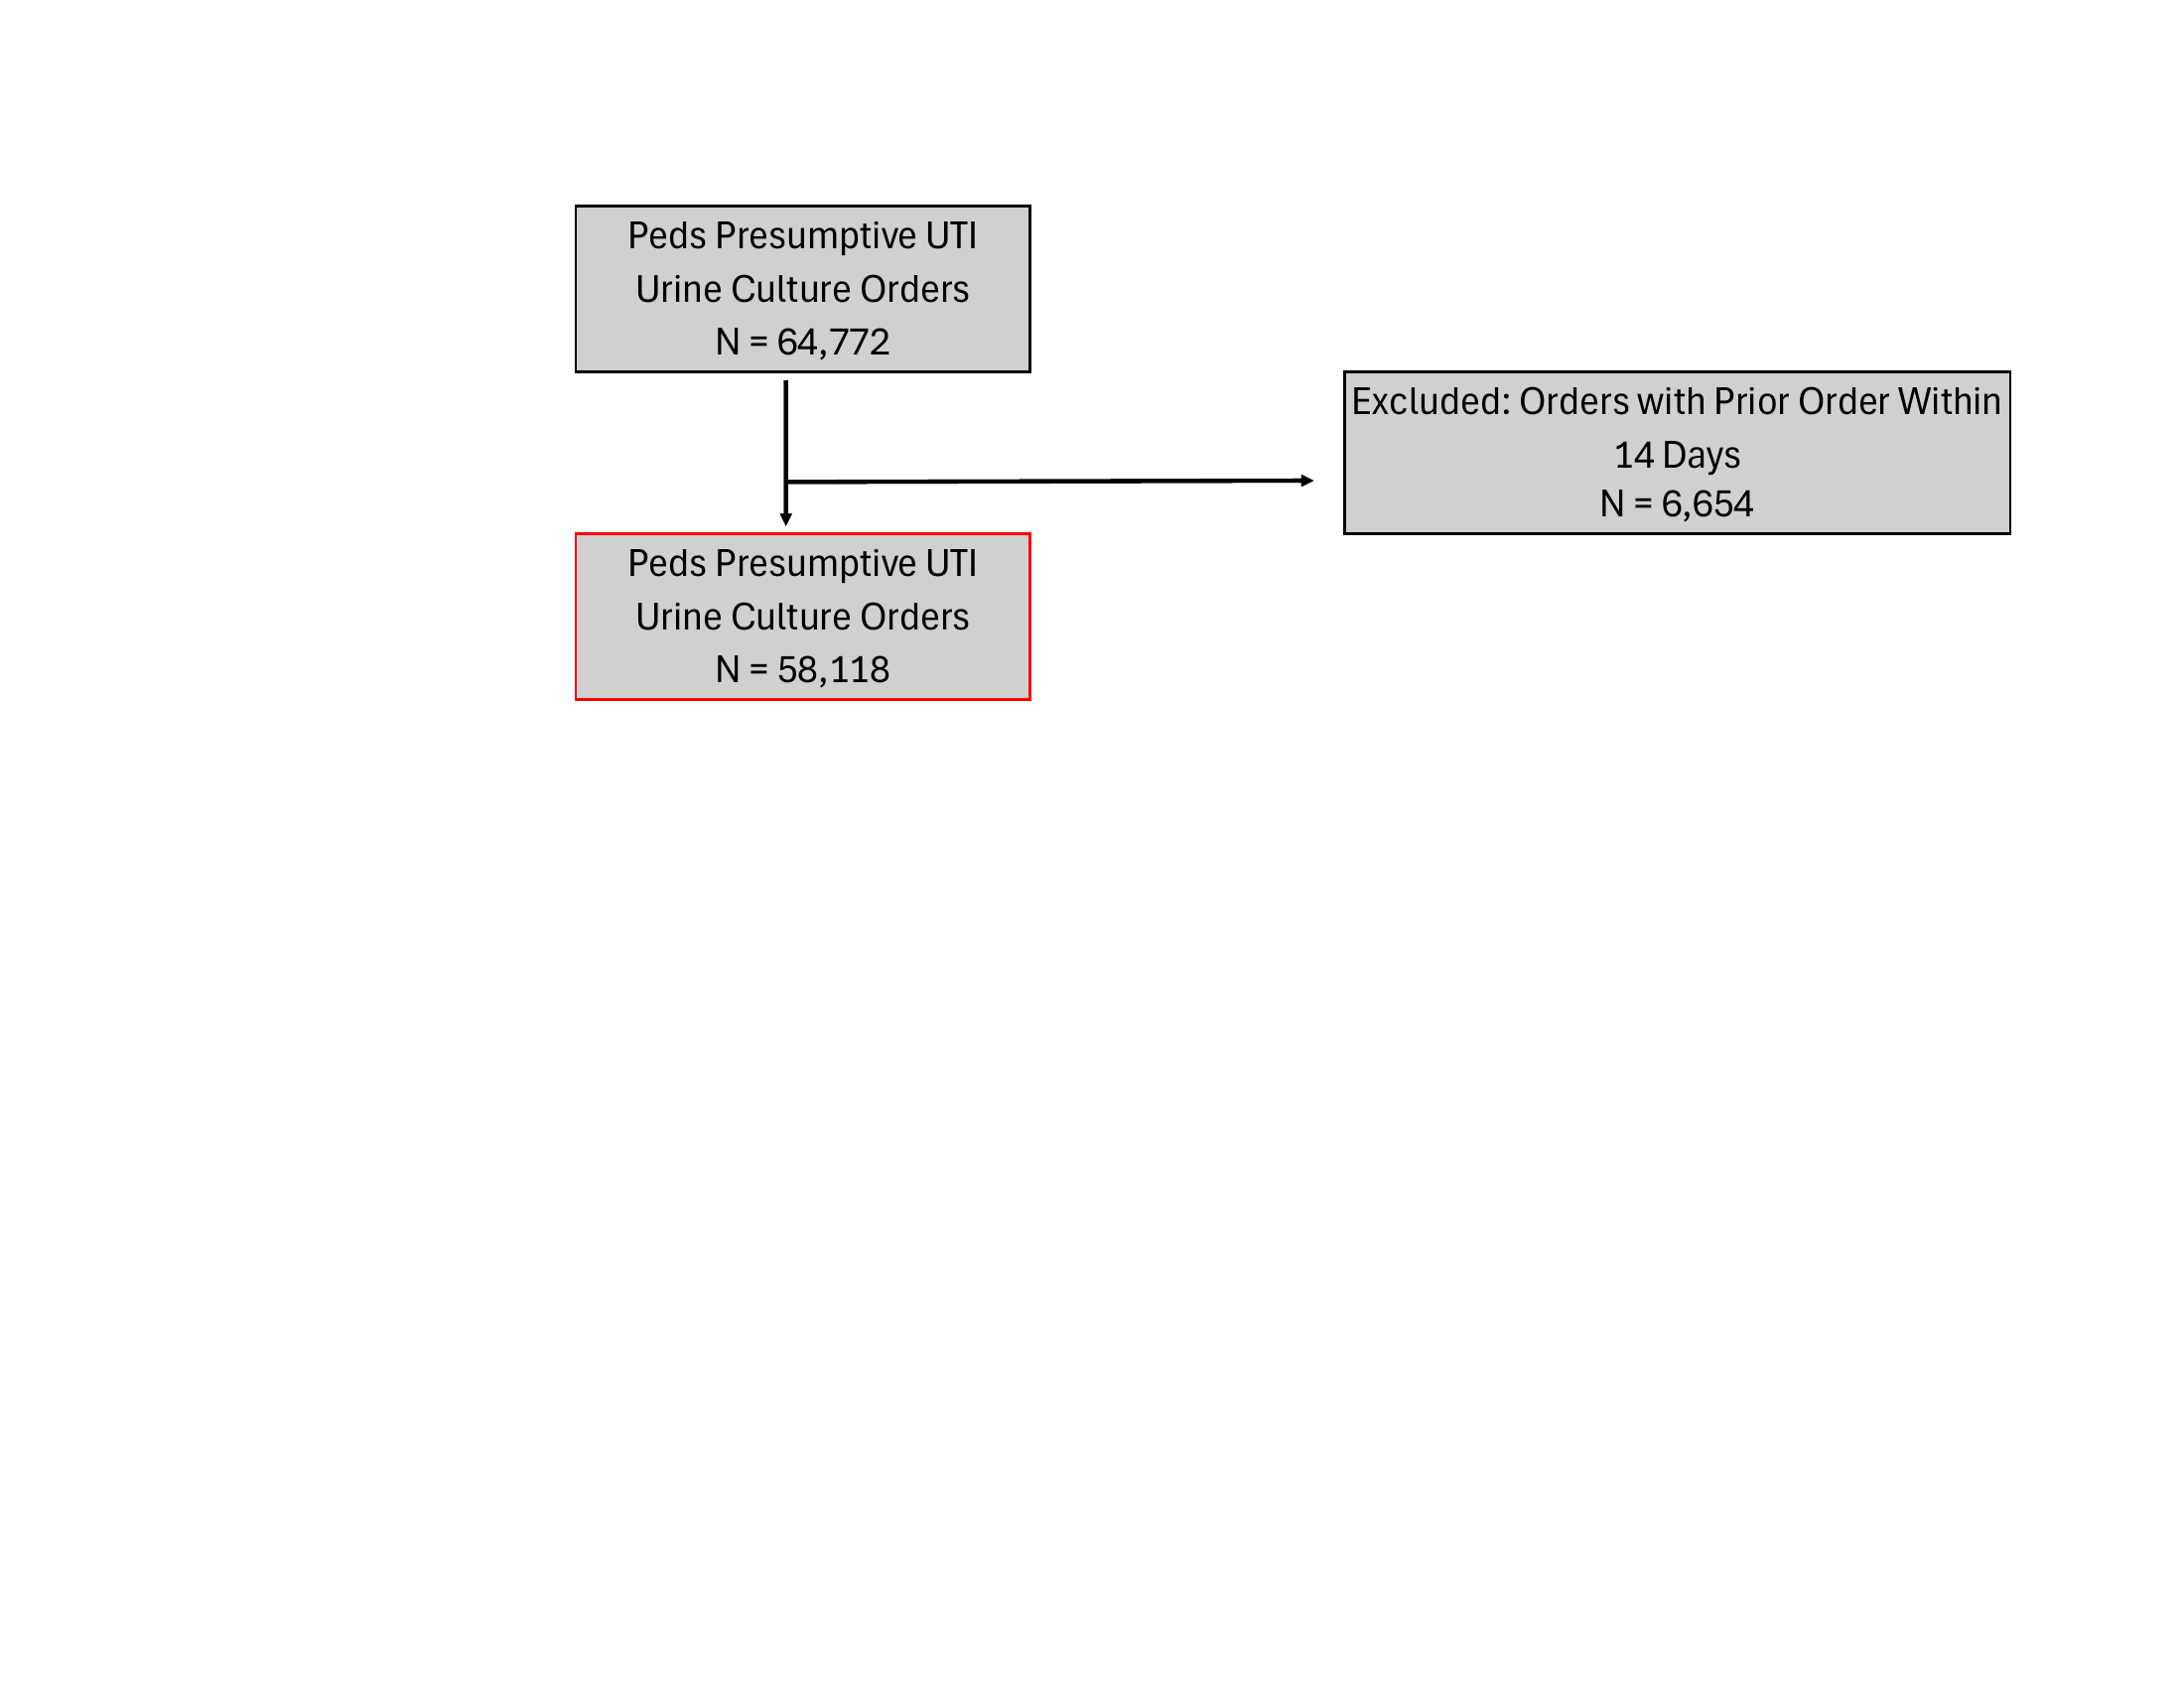

In [142]:
pages = convert_from_path('imgs/Aim_4_Flowchart_Custom_peds.pdf', dpi=200)
path_png = 'imgs/step1-2_peds.png'
pages[1].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))


In [8]:
%%bigquery --use_rest_api current_med_original_no_mapped_peds
##############################################################################################################################################################
# Goal:Creating the microbiology_cultures_prior_med_augmented Table. This table indicates of a patient having been treated with a specific antibiotic before specimen collection.
##############################################################################################################################################################
# CREATE OR REPLACE TABLE `som-nero-phi-jonc101.antimicrobial_stewardship.microbiology_cultures_prior_med_augmented` AS (
WITH base_c AS (
    SELECT DISTINCT
        anon_id,
        pat_enc_csn_id_coded,
        order_proc_id_coded,
        order_time_jittered_utc,
        result_time_jittered_utc
    FROM 
        `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.microbiology_urine_cultures_peds_cohort`
),
cleaned_medications AS (
    SELECT 
        c.anon_id,
        c.pat_enc_csn_id_coded,
        c.order_proc_id_coded,
        c.order_time_jittered_utc,
        c.result_time_jittered_utc,
        mo.ordering_date_jittered_utc AS medication_time,
        mo.med_description AS medication_name,
        mar.order_med_id_coded,
        mar.mar_action AS medication_action
        # INITCAP(
        #     REGEXP_REPLACE(
        #         REGEXP_REPLACE(
        #             TRIM(
        #                 REGEXP_REPLACE(
        #                     REGEXP_REPLACE(
        #                         REGEXP_REPLACE(
        #                             LOWER(mm.name),  -- Convert to lowercase
        #                             '\\s*\\d+(\\.\\d+)?\\s*(mg|mcg|gram|ml|%)', ''  -- Remove dosages or concentrations
        #                         ),
        #                         '\\(.*?\\)', ''  -- Remove text in parentheses
        #                     ),
        #                     ' in.*$|tablet|capsule|intravenous|piggyback|' ||
        #                     'solution|suspension|oral|sodium|chloride|' ||
        #                     'injection|citrate|soln|dextrose|iv|' ||
        #                     'macrocrystals|macrocrystal|axetil|potassium|packet|' ||
        #                     'monohydrate|ethylsuccinate|powder|mandelate|' ||
        #                     'hyclate|hcl|hippurate|tromethamine|' ||
        #                     'million|unit|syrup|chewable|delayed|mphase|' ||
        #                     'release|benzathine|syringe|dispersible|' ||
        #                     'sulfate|procaine|blue|hyos|sod*phos|' ||
        #                     'susp|and|fosamil|extended|succinate|granules|' ||
        #                     'delay|pot|ext|rel|cyam|salicylate|salicyl|' ||
        #                     'sodphos|methylene|stearate|synergy', ''  -- Remove pharmacy filler words and "synergy"
        #                 )
        #             ),
        #             '\\d|\\sfor\\s*|\\ser\\s*|\\shr\\s*|/ml\\s*|' ||
        #             '\\sml\\s*|\\sv\\s*|\\sg\\s*|\\sim\\s*', ''  -- General cleaning for non-relevant patterns
        #         ),
        #         '\\s|\\/|\\.|-$', ''  -- Remove extra characters like spaces, slashes, dots, etc.
        #     )
        # ) AS medication_name,
        # TIMESTAMP_DIFF(c.order_time_jittered_utc,mo.ordering_date_jittered_utc,day) as medication_time_to_cultureTime,       
    FROM 
        base_c c
    LEFT JOIN 
        `som-nero-phi-jonc101.shc_core_2023.order_med` mo
        using(anon_id, pat_enc_csn_id_coded) # I added "pat_enc_csn_id_coded" to search for current medications
    LEFT JOIN 
        `som-nero-phi-jonc101.shc_core_2023.pharmacy_mar` mar # I incorportedated the pharmacy_mar table to get the medication action
        on mo.anon_id = mar.anon_id 
        and mo.order_med_id_coded = mar.order_med_id_coded
        and mo.pat_enc_csn_id_coded = mar.mar_enc_csn_coded
)

select * 
from cleaned_medications 
group by anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc, medication_time, medication_name,order_med_id_coded, medication_action
order by anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc, medication_time,medication_name,order_med_id_coded, medication_action

Query is running:   0%|          |

Downloading:   0%|          |

In [9]:
# we check the unique order number for current_med_original_no_mapped and starting_cohort
assert find_unique_orders(current_med_original_no_mapped_peds) == find_unique_orders(peds_starting_cohort), "Unique order counts do not match between current_med_original_no_mapped and starting_cohort"

In [10]:
current_med_original_no_mapped_peds["medication_action"].value_counts()

medication_action
Given                            59767
New Bag                          11039
Due                               8428
Canceled Entry                    5739
Missed                            5163
Stopped                           4983
Completed                         2630
Held                               890
Contrast Given                     767
Rate Verify                        417
Rate Change                        353
MAR Hold                           342
MAR Unhold                         306
Given by Physician                 225
Refused                            210
Restarted                          170
See Override Pull                  137
Pump Check                         132
Patch Applied                      124
Complete                           116
Paused                              90
Existing Bag                        81
Infusion Stopped                    74
Automatically Held                  70
Patient's Own Med                   50
Dual Si

In [14]:
current_med_original_no_mapped_peds["cleaned_antibiotic"] = current_med_original_no_mapped_peds["medication_name"].apply(
    lambda x: find_antibiotics(x, antibiotic_list))

In [16]:
culture_order_with_any_cur_med =  current_med_original_no_mapped_peds[current_med_original_no_mapped_peds["cleaned_antibiotic"].notnull()]
culture_order_without_any_cur_med =  current_med_original_no_mapped_peds[current_med_original_no_mapped_peds["cleaned_antibiotic"].isnull()]
print("the unique order number for culture_order_with_any_cur_med is {}".format(find_unique_orders(culture_order_with_any_cur_med)))
print("the unique order number for culture_order_without_any_cur_med is {}".format(find_unique_orders(culture_order_without_any_cur_med)))

the unique order number for culture_order_with_any_cur_med is 28630
the unique order number for culture_order_without_any_cur_med is 29488


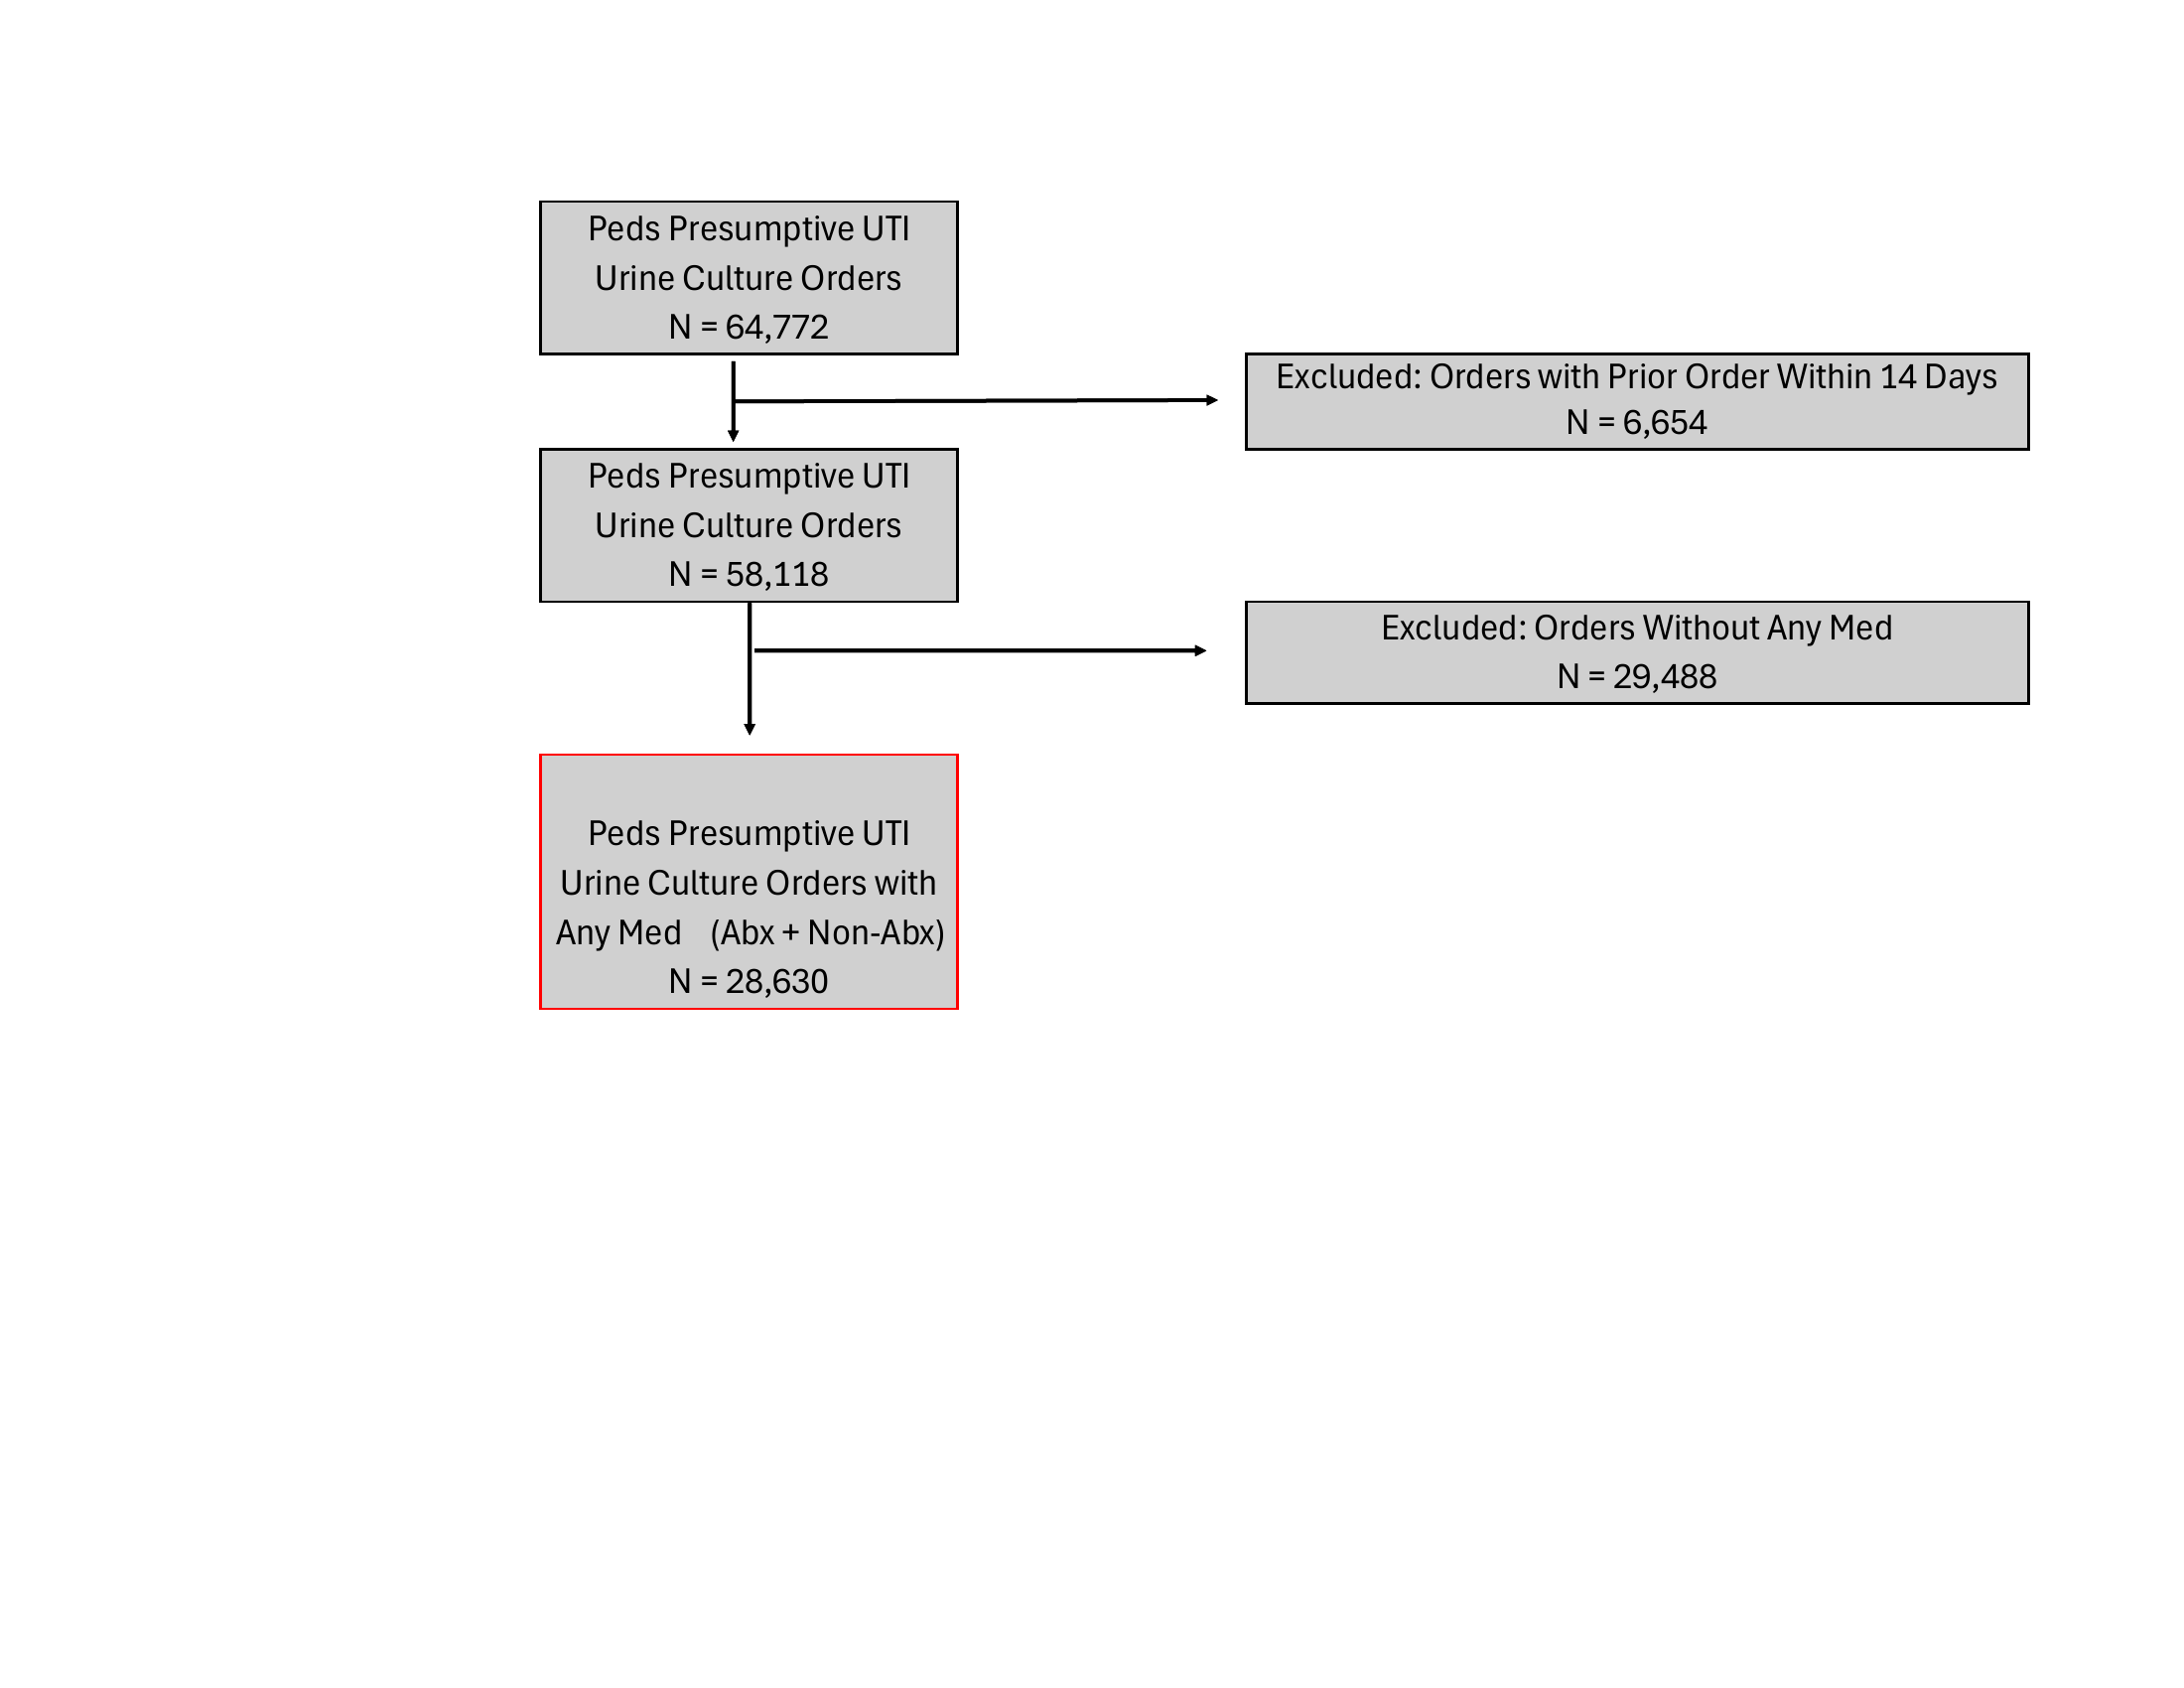

In [143]:
pages = convert_from_path('imgs/Aim_4_Flowchart_Custom_peds.pdf', dpi=200)
path_png = 'imgs/step3_peds.png'
pages[2].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))

In [17]:
culture_order_with_abx_med = culture_order_with_any_cur_med[culture_order_with_any_cur_med["cleaned_antibiotic"] != "No Match"]
culture_order_with_non_abx_med = culture_order_with_any_cur_med[culture_order_with_any_cur_med["cleaned_antibiotic"] == "No Match"]
print("the unique order number for culture_order_with_abx_med is {}".format(find_unique_orders(culture_order_with_abx_med)))
print("the unique order number for culture_order_with_non_abx_med is {}".format(find_unique_orders(culture_order_with_non_abx_med)))

the unique order number for culture_order_with_abx_med is 12585
the unique order number for culture_order_with_non_abx_med is 25873


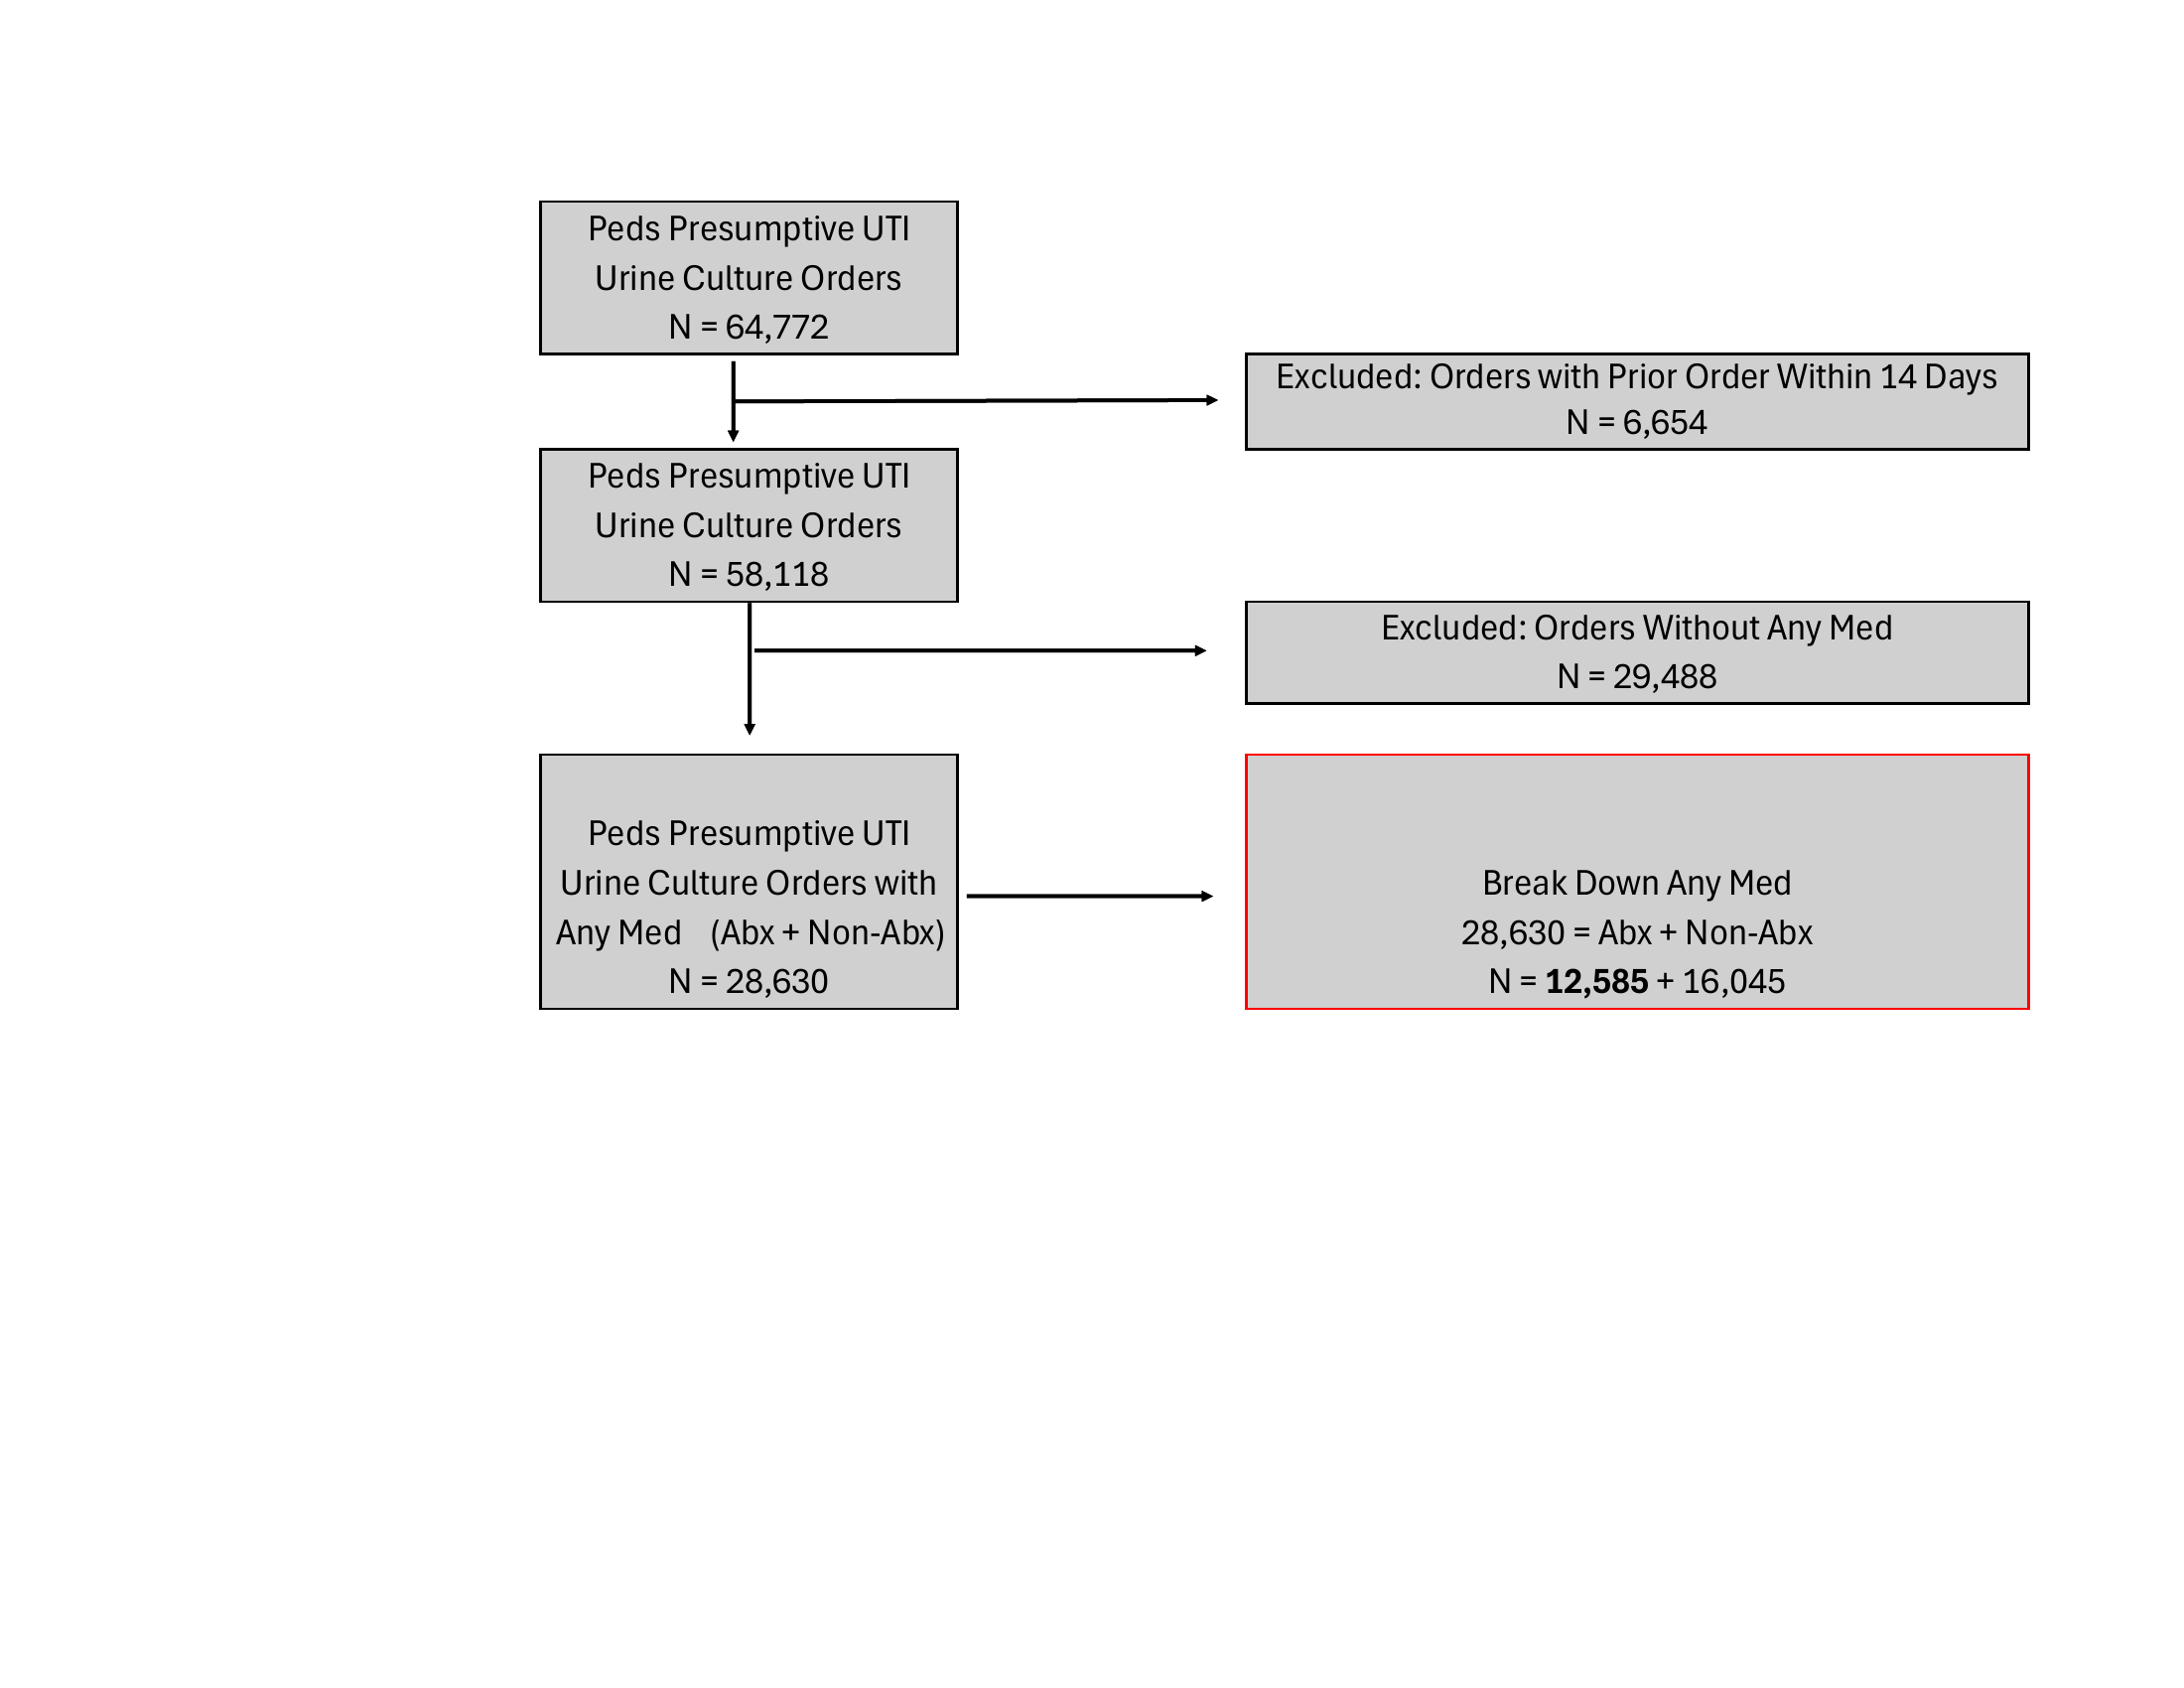

In [144]:
pages = convert_from_path('imgs/Aim_4_Flowchart_Custom_peds.pdf', dpi=200)
path_png = 'imgs/step3-1_peds.png'
pages[3].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))

In [19]:
culture_order_with_abx_med_given = culture_order_with_abx_med[culture_order_with_abx_med["medication_action"] == "Given"]
culture_order_with_abx_med_non_given = culture_order_with_abx_med[culture_order_with_abx_med["medication_action"]!= "Given"]
print("the unique order number for culture_order_with_abx_med_given is {}".format(find_unique_orders(culture_order_with_abx_med_given)))
print("the unique order number for culture_order_with_abx_med_non_given is {}".format(find_unique_orders(culture_order_with_abx_med_non_given)))

the unique order number for culture_order_with_abx_med_given is 6967
the unique order number for culture_order_with_abx_med_non_given is 10952


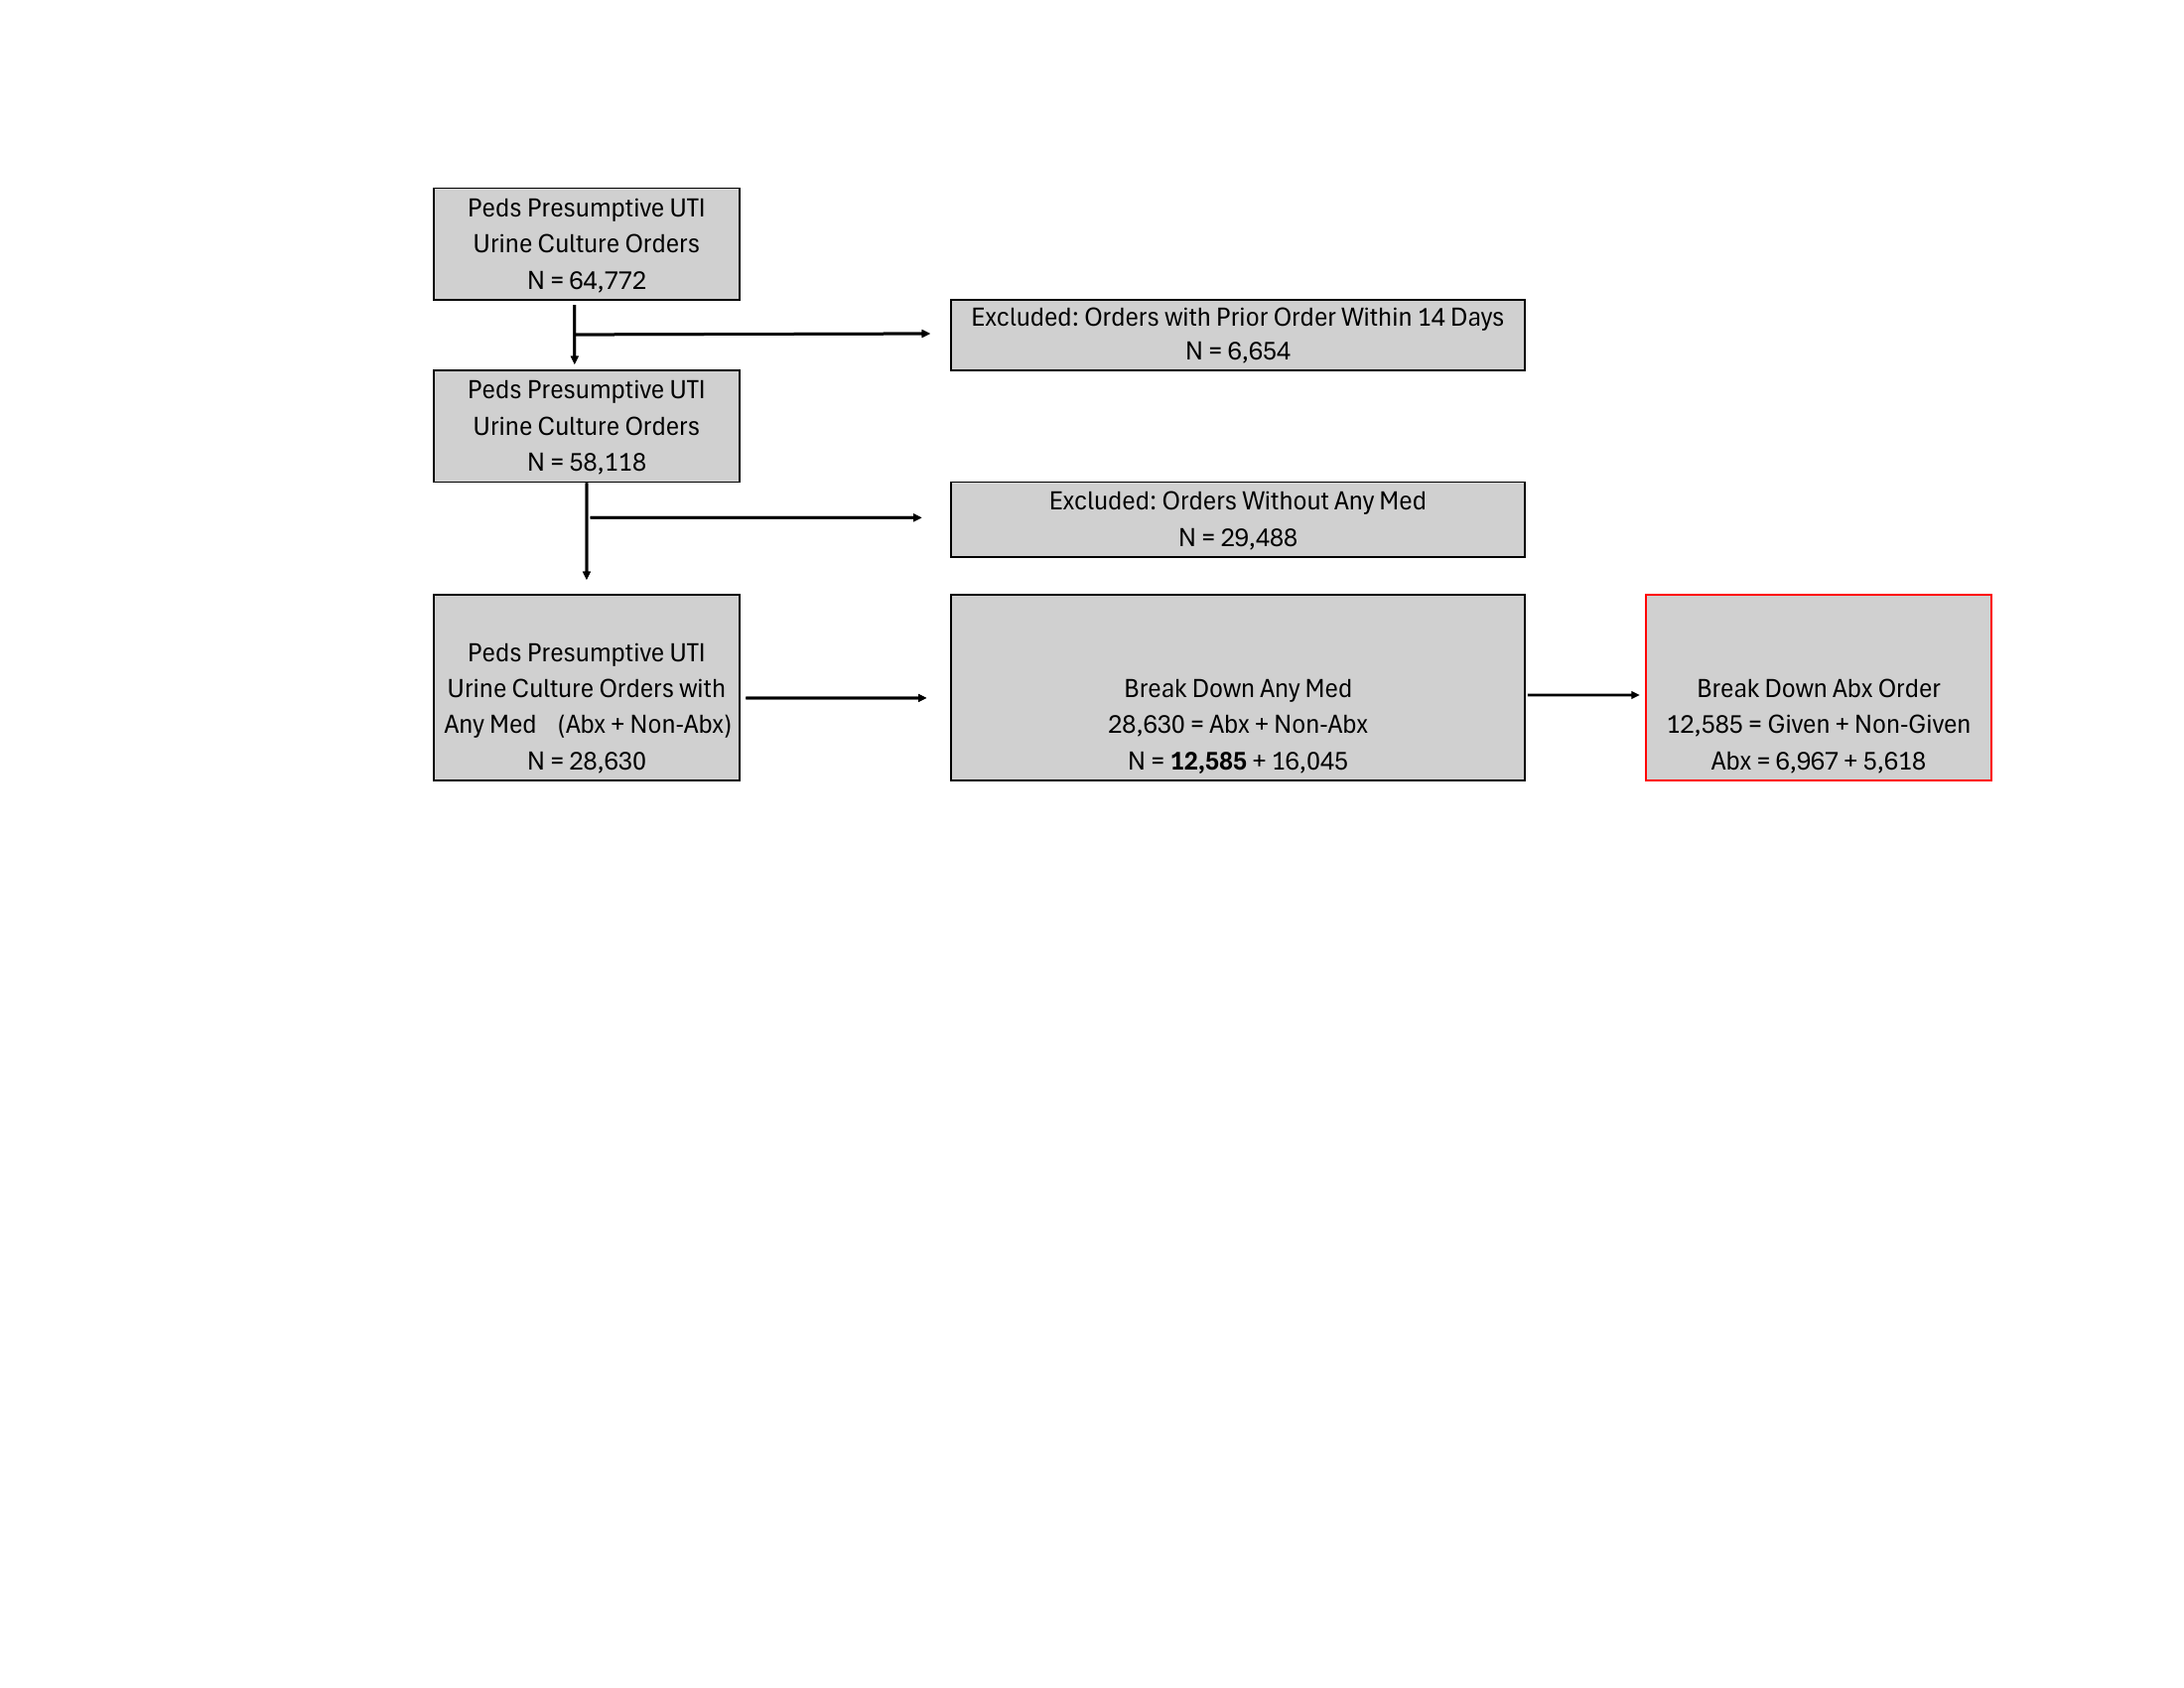

In [145]:
pages = convert_from_path('imgs/Aim_4_Flowchart_Custom_peds.pdf', dpi=200)
path_png = 'imgs/step3-2_peds.png'
pages[4].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))

In [20]:
%%bigquery --use_rest_api df_hosp_ward_info_peds
WITH
-- Step 1: Extract ER and ICU Information from adt Table
temp_er_icu_info_adt AS (
    SELECT
        anon_id,
        pat_enc_csn_id_coded,
        CASE 
            WHEN pat_class = 'Emergency' OR pat_class = 'Emergency Services' THEN 1
            ELSE 0
        END AS hosp_ward_ER,
        CASE 
            WHEN pat_class = 'Intensive Care (IC)' THEN 1
            ELSE 0
        END AS hosp_ward_ICU,
        CASE 
            WHEN pat_lv_of_care LIKE "%Critical Care" THEN 1
            ELSE 0
        END AS hosp_ward_Critical_Care
    FROM
        `som-nero-phi-jonc101.shc_core_2023.adt`
),

-- Step 2: Extract ER Information from order_proc Table
temp_er_info_order_proc AS (
    SELECT
        anon_id,
        pat_enc_csn_id_coded,
        order_proc_id_coded,
        CASE 
            WHEN proc_pat_class = 'Emergency' OR proc_pat_class = 'Emergency Services' THEN 1
            ELSE 0
        END AS hosp_ward_ER_order_proc
    FROM
        `som-nero-phi-jonc101.shc_core_2023.order_proc`
),

-- Step 3: Combine ER and ICU Information
temp_combined_er_icu_info AS (
    SELECT
        adt.anon_id,
        adt.pat_enc_csn_id_coded,
        adt.hosp_ward_ER,
        adt.hosp_ward_ICU,
        adt.hosp_ward_Critical_Care,
        er.order_proc_id_coded,
        er.hosp_ward_ER_order_proc
    FROM
        temp_er_icu_info_adt adt
    LEFT JOIN
        temp_er_info_order_proc er
    ON
        adt.pat_enc_csn_id_coded = er.pat_enc_csn_id_coded
),

-- Step 4: Extract IP and OP Information from order_proc Table
temp_ip_op_info AS (
    SELECT
        anon_id,
        pat_enc_csn_id_coded,
        order_proc_id_coded,
        order_time_jittered_utc,
        CASE 
            WHEN ordering_mode = 'Inpatient' THEN 1
            ELSE 0
        END AS hosp_ward_IP,
        CASE 
            WHEN ordering_mode = 'Outpatient' THEN 1
            ELSE 0
        END AS hosp_ward_OP
    FROM
        `som-nero-phi-jonc101.shc_core_2023.order_proc`
),

-- Step 5: Combine All Information into One Temporary Table
temp_combined_hosp_ward_info AS (
    SELECT
        ipop.anon_id,
        ipop.pat_enc_csn_id_coded,
        ipop.order_proc_id_coded,
        ipop.order_time_jittered_utc,
        ipop.hosp_ward_IP,
        ipop.hosp_ward_OP,
        COALESCE(icu.hosp_ward_ER, 0) AS hosp_ward_ER_adt,
        COALESCE(icu.hosp_ward_ER_order_proc, 0) AS hosp_ward_ER_order_proc,
        COALESCE(icu.hosp_ward_ICU, 0) AS hosp_ward_ICU,
        COALESCE(icu.hosp_ward_Critical_Care, 0) AS hosp_ward_Critical_Care
    FROM
        temp_ip_op_info ipop
    LEFT JOIN
        temp_combined_er_icu_info icu
    ON
        ipop.pat_enc_csn_id_coded = icu.pat_enc_csn_id_coded AND ipop.order_proc_id_coded = icu.order_proc_id_coded
),

-- Step 6: Extract ICU stay based on transfer orders
temp_cohortOfInterest AS (
    SELECT DISTINCT
        pat_enc_csn_id_coded,
        hosp_disch_time_jittered_utc
    FROM `som-nero-phi-jonc101.shc_core_2023.encounter`
    WHERE hosp_disch_time_jittered_utc IS NOT NULL
),

temp_ordersTransfer AS (
    SELECT DISTINCT
        pat_enc_csn_id_coded,
        description,
        level_of_care,
        service,
        order_inst_jittered_utc
    FROM `som-nero-phi-jonc101.shc_core_2023.order_proc` AS procedures
    WHERE (description LIKE "CHANGE LEVEL OF CARE/TRANSFER PATIENT" OR description LIKE "ADMIT TO INPATIENT") AND level_of_care IS NOT NULL
),

temp_icuTransferCount AS (
    SELECT
        mc.pat_enc_csn_id_coded,
        COUNT(CASE WHEN level_of_care LIKE "Critical Care" THEN 1 END) AS numICUTransfers
    FROM
       `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.microbiology_urine_cultures_peds_cohort` mc # only change this to the starting cohort above
    LEFT JOIN
        temp_ordersTransfer ot
    ON
        mc.pat_enc_csn_id_coded = ot.pat_enc_csn_id_coded
    GROUP BY
        mc.pat_enc_csn_id_coded
),

microbiology_cultures_with_icu_flag AS (
    SELECT DISTINCT
        mc.anon_id,
        mc.pat_enc_csn_id_coded,
        mc.order_proc_id_coded,
        mc.order_time_jittered_utc,
        CASE WHEN itc.numICUTransfers > 0 THEN 1 ELSE 0 END AS icu_flag
    FROM
       `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.microbiology_urine_cultures_peds_cohort` mc
    LEFT JOIN
        temp_icuTransferCount itc
    ON
        mc.pat_enc_csn_id_coded = itc.pat_enc_csn_id_coded
)

-- Step 7: Create the Final Table with Correct Binary Indicators for Each Hospital Ward and ICU Flag
SELECT
    mc.anon_id,
    mc.pat_enc_csn_id_coded,
    mc.order_proc_id_coded,
    mc.order_time_jittered_utc,
    MAX(CASE WHEN chwi.hosp_ward_IP = 1 THEN 1 ELSE 0 END) AS hosp_ward_IP,
    MAX(CASE WHEN chwi.hosp_ward_OP = 1 THEN 1 ELSE 0 END) AS hosp_ward_OP,
    MAX(CASE WHEN chwi.hosp_ward_ER_adt = 1 OR chwi.hosp_ward_ER_order_proc = 1 THEN 1 ELSE 0 END) AS hosp_ward_ER,
    MAX(
        CASE 
            WHEN chwi.hosp_ward_ICU = 1 THEN 1 
            WHEN icu_flag.icu_flag = 1 THEN 1 
            WHEN chwi.hosp_ward_Critical_Care = 1 THEN 1
            ELSE 0 
        END
    ) AS hosp_ward_ICU
FROM
   `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.microbiology_urine_cultures_peds_cohort` mc
LEFT JOIN
    temp_combined_hosp_ward_info chwi
ON
    mc.anon_id = chwi.anon_id 
    AND mc.pat_enc_csn_id_coded = chwi.pat_enc_csn_id_coded 
    AND mc.order_proc_id_coded = chwi.order_proc_id_coded
LEFT JOIN
    microbiology_cultures_with_icu_flag icu_flag
ON
    mc.anon_id = icu_flag.anon_id 
    AND mc.pat_enc_csn_id_coded = icu_flag.pat_enc_csn_id_coded 
    AND mc.order_proc_id_coded = icu_flag.order_proc_id_coded
GROUP BY
    mc.anon_id, 
    mc.pat_enc_csn_id_coded, 
    mc.order_proc_id_coded, 
    mc.order_time_jittered_utc;

Query is running:   0%|          |

Downloading:   0%|          |

In [21]:
assert find_unique_orders(df_hosp_ward_info_peds) == find_unique_orders(peds_starting_cohort), "Unique order counts do not match between df_hosp_ward_info and starting_cohort"

In [22]:
ED_order = df_hosp_ward_info_peds[df_hosp_ward_info_peds['hosp_ward_ER'] == 1]
ED_order

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,hosp_ward_IP,hosp_ward_OP,hosp_ward_ER,hosp_ward_ICU
27504,JC2223009,131008584897,363770215,2010-03-14 10:41:00+00:00,1,0,1,0
27506,JC2405820,131363222672,908060497,2023-10-23 09:56:00+00:00,1,0,1,0
27507,JC2893972,131313524054,734315103,2021-07-09 17:29:00+00:00,1,0,1,0
27508,JC2242662,131022850023,414423501,2013-01-23 21:51:00+00:00,1,0,1,0
27509,JC2422585,131346089155,841512533,2022-12-23 03:15:00+00:00,1,0,1,0
...,...,...,...,...,...,...,...,...
58113,JC2345229,131201948856,507072068,2016-10-31 01:18:00+00:00,1,0,1,0
58114,JC2471297,131011539556,375283397,2010-12-18 17:58:00+00:00,1,0,1,0
58115,JC2785423,131264678878,597754385,2019-03-23 07:00:00+00:00,1,0,1,0
58116,JC6240826,131325230380,770515146,2021-12-29 19:22:00+00:00,1,0,1,0


In [23]:
ED_culture_order_with_any_med =  culture_order_with_any_cur_med.merge(ED_order, on=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'], how='inner')
ED_culture_order_with_abx_med =  culture_order_with_abx_med.merge(ED_order, on=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'], how='inner')

In [24]:
print("the unique order number for ED_culture_order_with_any_med is {}".format(find_unique_orders(ED_culture_order_with_any_med)))
print("the unique order number for ED_culture_order_with_abx_med is {}".format(find_unique_orders(ED_culture_order_with_abx_med)))

the unique order number for ED_culture_order_with_any_med is 24576
the unique order number for ED_culture_order_with_abx_med is 10277


In [147]:
ED_culture_order_with_abx_med_given = ED_culture_order_with_abx_med[ED_culture_order_with_abx_med["medication_action"] == "Given"]
ED_culture_order_with_abx_med_non_given = ED_culture_order_with_abx_med[ED_culture_order_with_abx_med["medication_action"]!= "Given"]
print("the unique order number for ED_culture_order_with_abx_med_given is {}".format(find_unique_orders(ED_culture_order_with_abx_med_given)))
print("the unique order number for ED_culture_order_with_abx_med_non_given is {}".format(find_unique_orders(ED_culture_order_with_abx_med) - find_unique_orders(ED_culture_order_with_abx_med_given)))

the unique order number for ED_culture_order_with_abx_med_given is 6290
the unique order number for ED_culture_order_with_abx_med_non_given is 3987


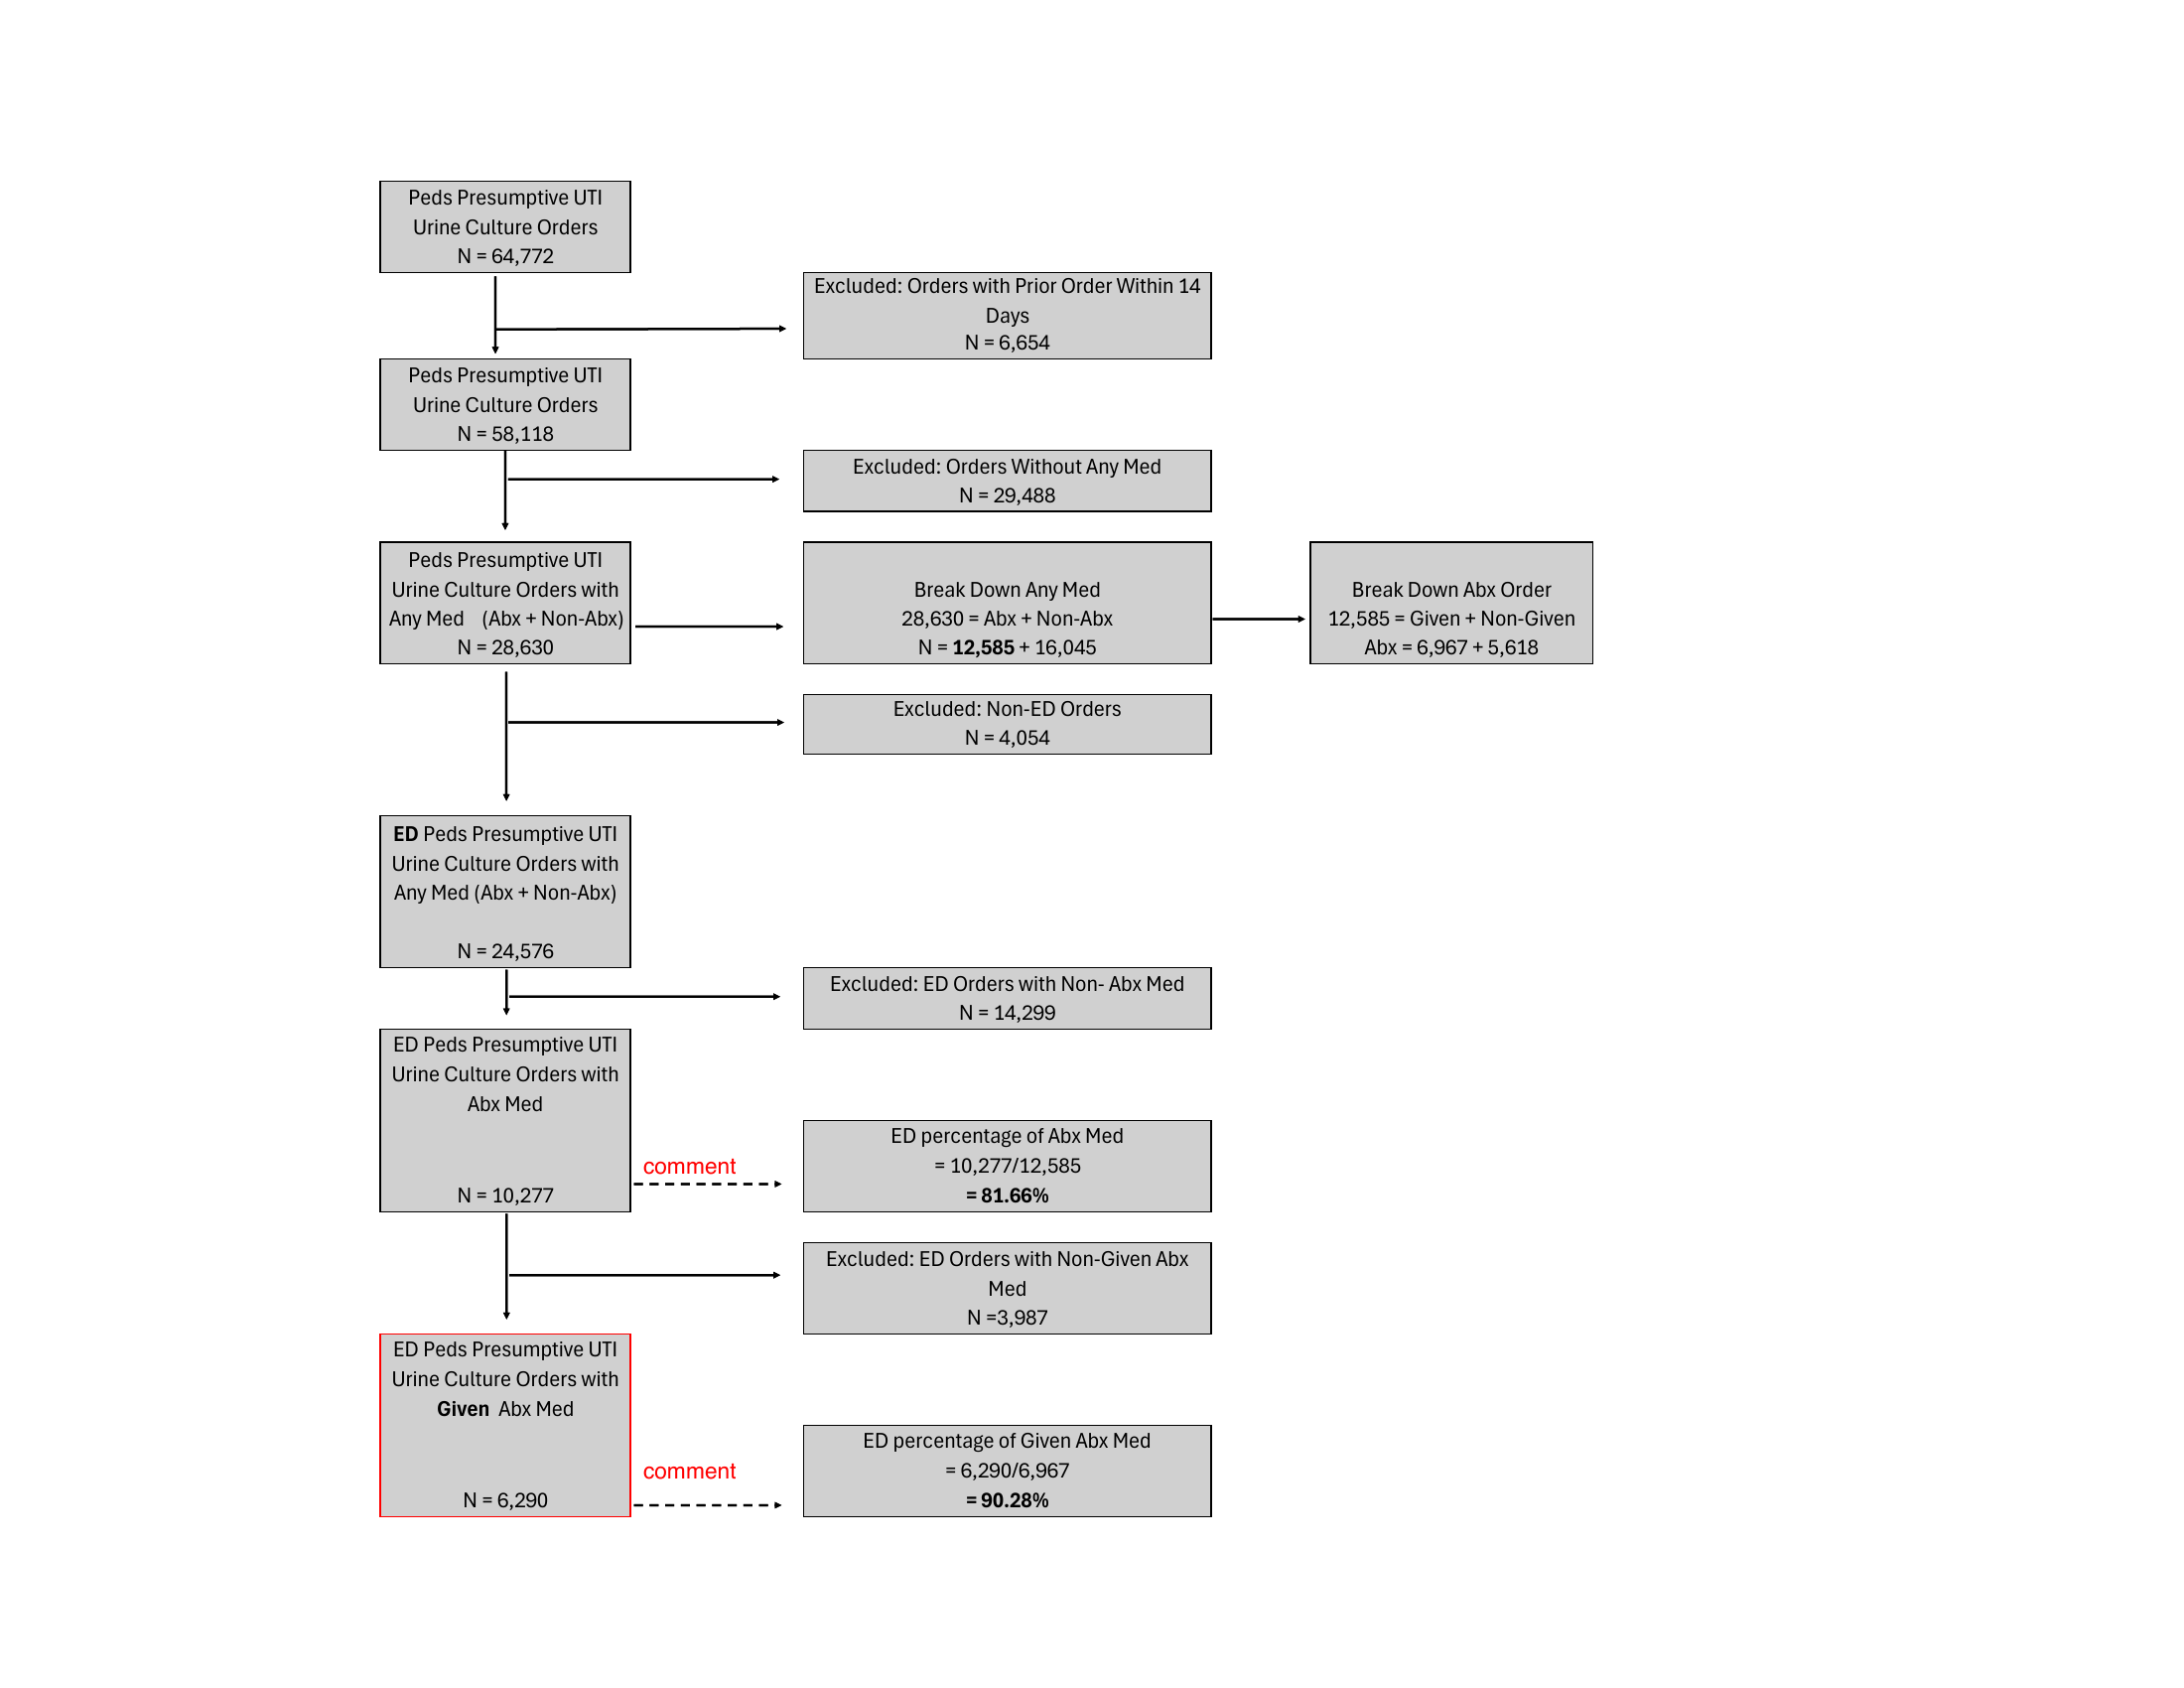

In [149]:
pages = convert_from_path('imgs/Aim_4_Flowchart_Custom_peds.pdf', dpi=200)
path_png = 'imgs/step4-2_peds.png.png'
pages[6].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))

In [26]:
ED_culture_order_with_abx_med_given = ED_culture_order_with_abx_med_given.drop(columns=['hosp_ward_IP', 'hosp_ward_OP', 'hosp_ward_ER', 'hosp_ward_ICU'])

In [27]:
# Group by the specified columns
grouped = ED_culture_order_with_abx_med_given.groupby(['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])

# Function to filter each group
def filter_group(group):
        # Keep rows where:
        # 1. medication_time is greater than culture order time but smaller than result time, OR
        # 2. medication_time is within 6 hours before the culture order time
    condition = (
        ((group['medication_time'] > group['order_time_jittered_utc']) & 
            (group['medication_time'] < group['result_time_jittered_utc'])) | 
        ((group['medication_time'] >= (group['order_time_jittered_utc'] - pd.Timedelta(hours=6))) & 
            (group['medication_time'] <= group['order_time_jittered_utc'])
    ))
    return group[condition]

# Apply the filter to each group
filtered_groups = [filter_group(group) for _, group in grouped]

# Combine the filtered groups into a new DataFrame
filtered_df = pd.concat([group for group in filtered_groups if group is not None])

# Reset the index
# filtered_df = filtered_df.reset_index(drop=True)


In [29]:
find_unique_orders(filtered_df)

1960

In [30]:
filtered_df.to_csv('../csv_folder/filtered_df_peds.csv', index=False)

In [133]:
filtered_df

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,medication_time,medication_name,order_med_id_coded,medication_action,cleaned_antibiotic
2,JC1000924,131014644911,387581858,2011-07-25 05:14:00+00:00,2011-07-27 02:24:00+00:00,2011-07-25 07:00:00+00:00,CEPHALEXIN 250 MG PO CAPS,387591109.000000000,Given,[Cephalexin]
4,JC1000924,131014644911,387581858,2011-07-25 05:14:00+00:00,2011-07-27 02:24:00+00:00,2011-07-25 07:00:00+00:00,SULFAMETHOXAZOLE-TRIMETHOPRIM 400-80 MG PO TABS,387591245.000000000,Given,"[Sulfamethoxazole-Trimethoprim, Trimethoprim]"
9,JC1001971,131011493486,375107375,2010-10-28 06:49:00+00:00,2010-10-30 05:01:00+00:00,2010-10-28 07:00:00+00:00,SULFAMETHOXAZOLE-TRIMETHOPRIM 200-40 MG/5 ML P...,375117174.000000000,Given,"[Sulfamethoxazole-Trimethoprim, Trimethoprim]"
11,JC1002179,131072441287,457316754,2015-01-25 11:53:00+00:00,2015-01-27 16:14:00+00:00,2015-01-25 08:00:00+00:00,AZITHROMYCIN 200 MG/5 ML PO SUSR,457317321.000000000,Given,[Azithromycin]
12,JC1002389,131267063911,607395745,2019-04-20 04:48:00+00:00,2019-04-22 17:28:00+00:00,2019-04-20 07:00:00+00:00,CEFTRIAXONE 1 GRAM/10 ML IV PUSH (VIAL ONLY),607402212.000000000,Given,[Ceftriaxone]
...,...,...,...,...,...,...,...,...,...,...
21899,JC992265,131294446733,681722202,2020-09-03 05:15:00+00:00,2020-09-06 22:13:00+00:00,2020-09-03 07:00:00+00:00,CIPROFLOXACIN HCL 500 MG PO TABS,681744691.000000000,Given,"[Ciprofloxacin Hcl, Cipro, Ciprofloxacin, Oflo..."
21907,JC992950,131009855650,368842326,2010-06-16 07:13:00+00:00,2010-06-18 15:01:00+00:00,2010-06-16 07:00:00+00:00,CEPHALEXIN 250 MG/5 ML PO SUSR,368848771.000000000,Given,[Cephalexin]
21911,JC994133,131010591909,371678474,2010-09-14 07:14:00+00:00,2010-09-16 15:50:00+00:00,2010-09-14 07:00:00+00:00,CEPHALEXIN 250 MG/5 ML PO SUSR,371678482.000000000,Given,[Cephalexin]
21914,JC994170,131238135121,535534546,2017-09-27 11:06:00+00:00,2017-09-29 18:27:00+00:00,2017-09-27 07:00:00+00:00,SULFAMETHOXAZOLE-TRIMETHOPRIM 800-160 MG PO TABS,535533342.000000000,Given,"[Sulfamethoxazole-Trimethoprim, Trimethoprim]"


In [31]:
print("the unique order number for empirical abx med order is {}".format(find_unique_orders(filtered_df)))
print("the unique order number for non empirical abx med order is {}"\
      .format(find_unique_orders(ED_culture_order_with_abx_med_given) -find_unique_orders(filtered_df)))

the unique order number for empirical abx med order is 1960
the unique order number for non empirical abx med order is 4330


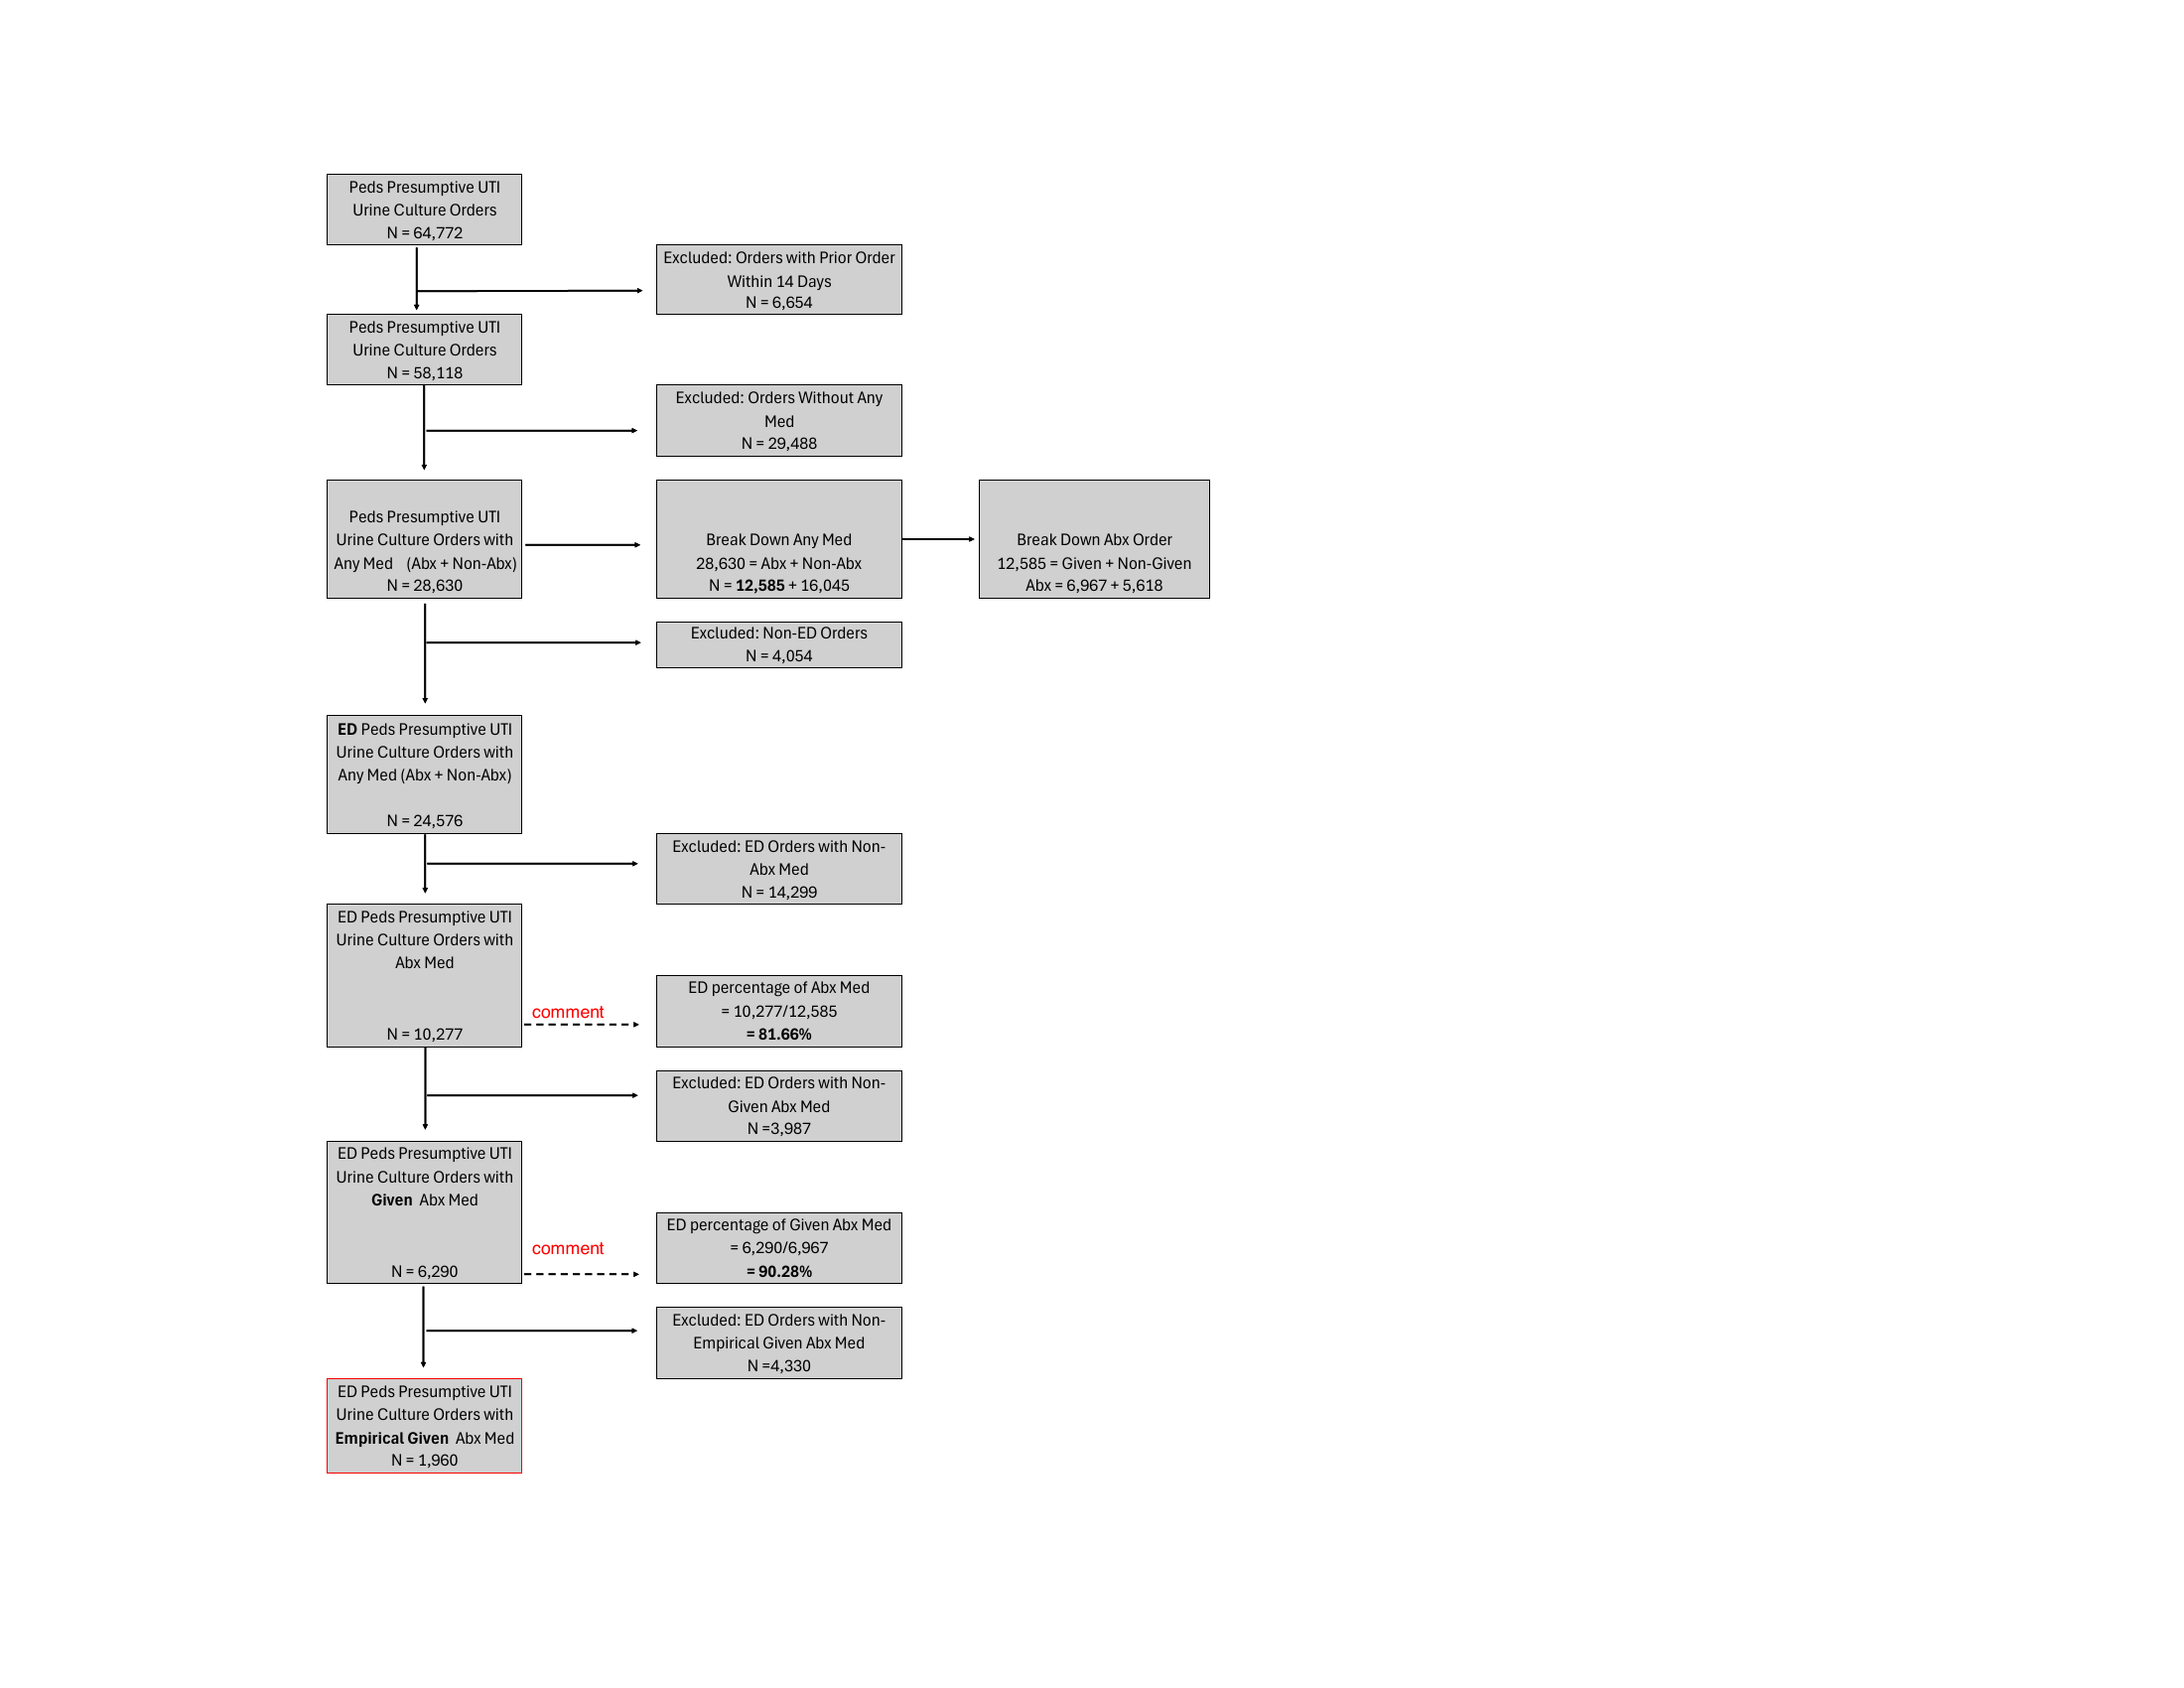

In [150]:
pages = convert_from_path('imgs/Aim_4_Flowchart_Custom_peds.pdf', dpi=200)
path_png = 'imgs/step5_peds.png'
pages[7].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))

In [135]:
%%bigquery --use_rest_api final_cohort_peds

WITH exclusion AS (
    SELECT
      distinct
        anon_id,
        pat_enc_csn_id_coded,
        order_proc_id_coded,
        order_time_jittered_utc
    FROM
        `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.all_med_peds` al
    INNER JOIN 
        `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.step_5_filtered_df_peds` m
    USING
        (anon_id, pat_enc_csn_id_coded, order_proc_id_coded, order_time_jittered_utc)
    WHERE
    al.medication_time IS NOT NULL
    AND ARRAY_LENGTH(al.cleaned_antibiotic) > 0 
    AND al.medication_action like "Given"
    AND TIMESTAMP_DIFF(al.medication_time, al.order_time_jittered_utc, HOUR) > -720
    AND TIMESTAMP_DIFF(al.medication_time, al.order_time_jittered_utc, HOUR) < -6
),

filtered_groups AS (
    SELECT
        m.*
    FROM
         `som-nero-phi-jonc101.antimicrobial_stewardship_sandy_refactor.step_5_filtered_df_peds` m
    WHERE
        -- Disregard groups where any medication_time is between 6 and 720 hours after order_time_jittered_utc
        NOT EXISTS (
            SELECT 1
            FROM exclusion ex
            WHERE
                ex.anon_id = m.anon_id
                AND ex.pat_enc_csn_id_coded = m.pat_enc_csn_id_coded
                AND ex.order_proc_id_coded = m.order_proc_id_coded
                AND ex.order_time_jittered_utc = m.order_time_jittered_utc
        )
)
SELECT 
*
    -- distinct
    -- anon_id,
    -- pat_enc_csn_id_coded,
    -- order_proc_id_coded,
    -- order_time_jittered_utc
    -- -- medication_time,
    -- -- result_time_jittered_utc
    -- -- medication_name,

FROM
    filtered_groups
ORDER BY
    anon_id,
    pat_enc_csn_id_coded,
    order_proc_id_coded,
    order_time_jittered_utc

Query is running:   0%|          |

Downloading:   0%|          |

In [136]:
# This also brings up another problem: how do we actually want to evaluate appropriteness of medication prescription for one culture order.
# Nick could talk more about this
# Count number of rows per group
group_counts = final_cohort_peds.groupby(
    ['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc']
)['cleaned_antibiotic'].transform('count')

# Filter rows where group count is greater than 1
group_counts_df= final_cohort_peds[group_counts > 1]
sorted_group_counts_df = group_counts_df.sort_values(by=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])
# sorted_group_counts_df.head(50)
sorted_group_counts_df

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,medication_time,medication_name,order_med_id_coded,medication_action,cleaned_antibiotic
0,JC1000924,131014644911,387581858,2011-07-25 05:14:00+00:00,2011-07-27 02:24:00+00:00,2011-07-25 07:00:00+00:00,CEPHALEXIN 250 MG PO CAPS,387591109.0,Given,['Cephalexin']
1,JC1000924,131014644911,387581858,2011-07-25 05:14:00+00:00,2011-07-27 02:24:00+00:00,2011-07-25 07:00:00+00:00,SULFAMETHOXAZOLE-TRIMETHOPRIM 400-80 MG PO TABS,387591245.0,Given,"['Sulfamethoxazole-Trimethoprim', 'Trimethoprim']"
11,JC1009787,131019502504,403504799,2012-07-19 02:49:00+00:00,2012-07-21 16:12:00+00:00,2012-07-19 07:00:00+00:00,CEFTRIAXONE PEDIATRIC IV INFUSION,403518155.0,Given,['Ceftriaxone']
12,JC1009787,131019502504,403504799,2012-07-19 02:49:00+00:00,2012-07-21 16:12:00+00:00,2012-07-19 07:00:00+00:00,VANCOMYCIN PEDIATRIC IV INFUSION,403518554.0,Given,['Vancomycin']
37,JC1054889,131020147678,405541285,2012-09-10 09:20:00+00:00,2012-09-12 15:14:00+00:00,2012-09-10 07:00:00+00:00,CEFTRIAXONE PEDIATRIC IM INJECTION,405542350.0,Given,['Ceftriaxone']
...,...,...,...,...,...,...,...,...,...,...
2020,JC6537055,131363577818,909256933,2023-09-07 08:22:00+00:00,2023-09-09 05:15:00+00:00,2023-09-07 07:00:00+00:00,CEPHALEXIN 500 MG PO CAPS,909259473.0,Given,['Cephalexin']
2030,JC975867,131029432861,433587832,2013-12-30 05:14:00+00:00,2014-01-01 16:29:00+00:00,2013-12-30 08:00:00+00:00,MEROPENEM IVPB,433602528.0,Given,['Meropenem']
2031,JC975867,131029432861,433587832,2013-12-30 05:14:00+00:00,2014-01-01 16:29:00+00:00,2013-12-30 08:00:00+00:00,VANCOMYCIN PEDIATRIC IV INFUSION,433602534.0,Given,['Vancomycin']
2034,JC977071,131243318147,546794293,2017-12-25 07:53:00+00:00,2017-12-27 18:47:00+00:00,2017-12-25 08:00:00+00:00,CEFTRIAXONE PEDIATRIC IV INFUSION,546804446.0,Given,['Ceftriaxone']


In [137]:
print("the unique order number for final_cohort is {}".format(find_unique_orders(final_cohort_peds)))
print("the unique order number from final cohort that has more than one medication is {}".format(find_unique_orders(sorted_group_counts_df)))

the unique order number for final_cohort is 1847
the unique order number from final cohort that has more than one medication is 179


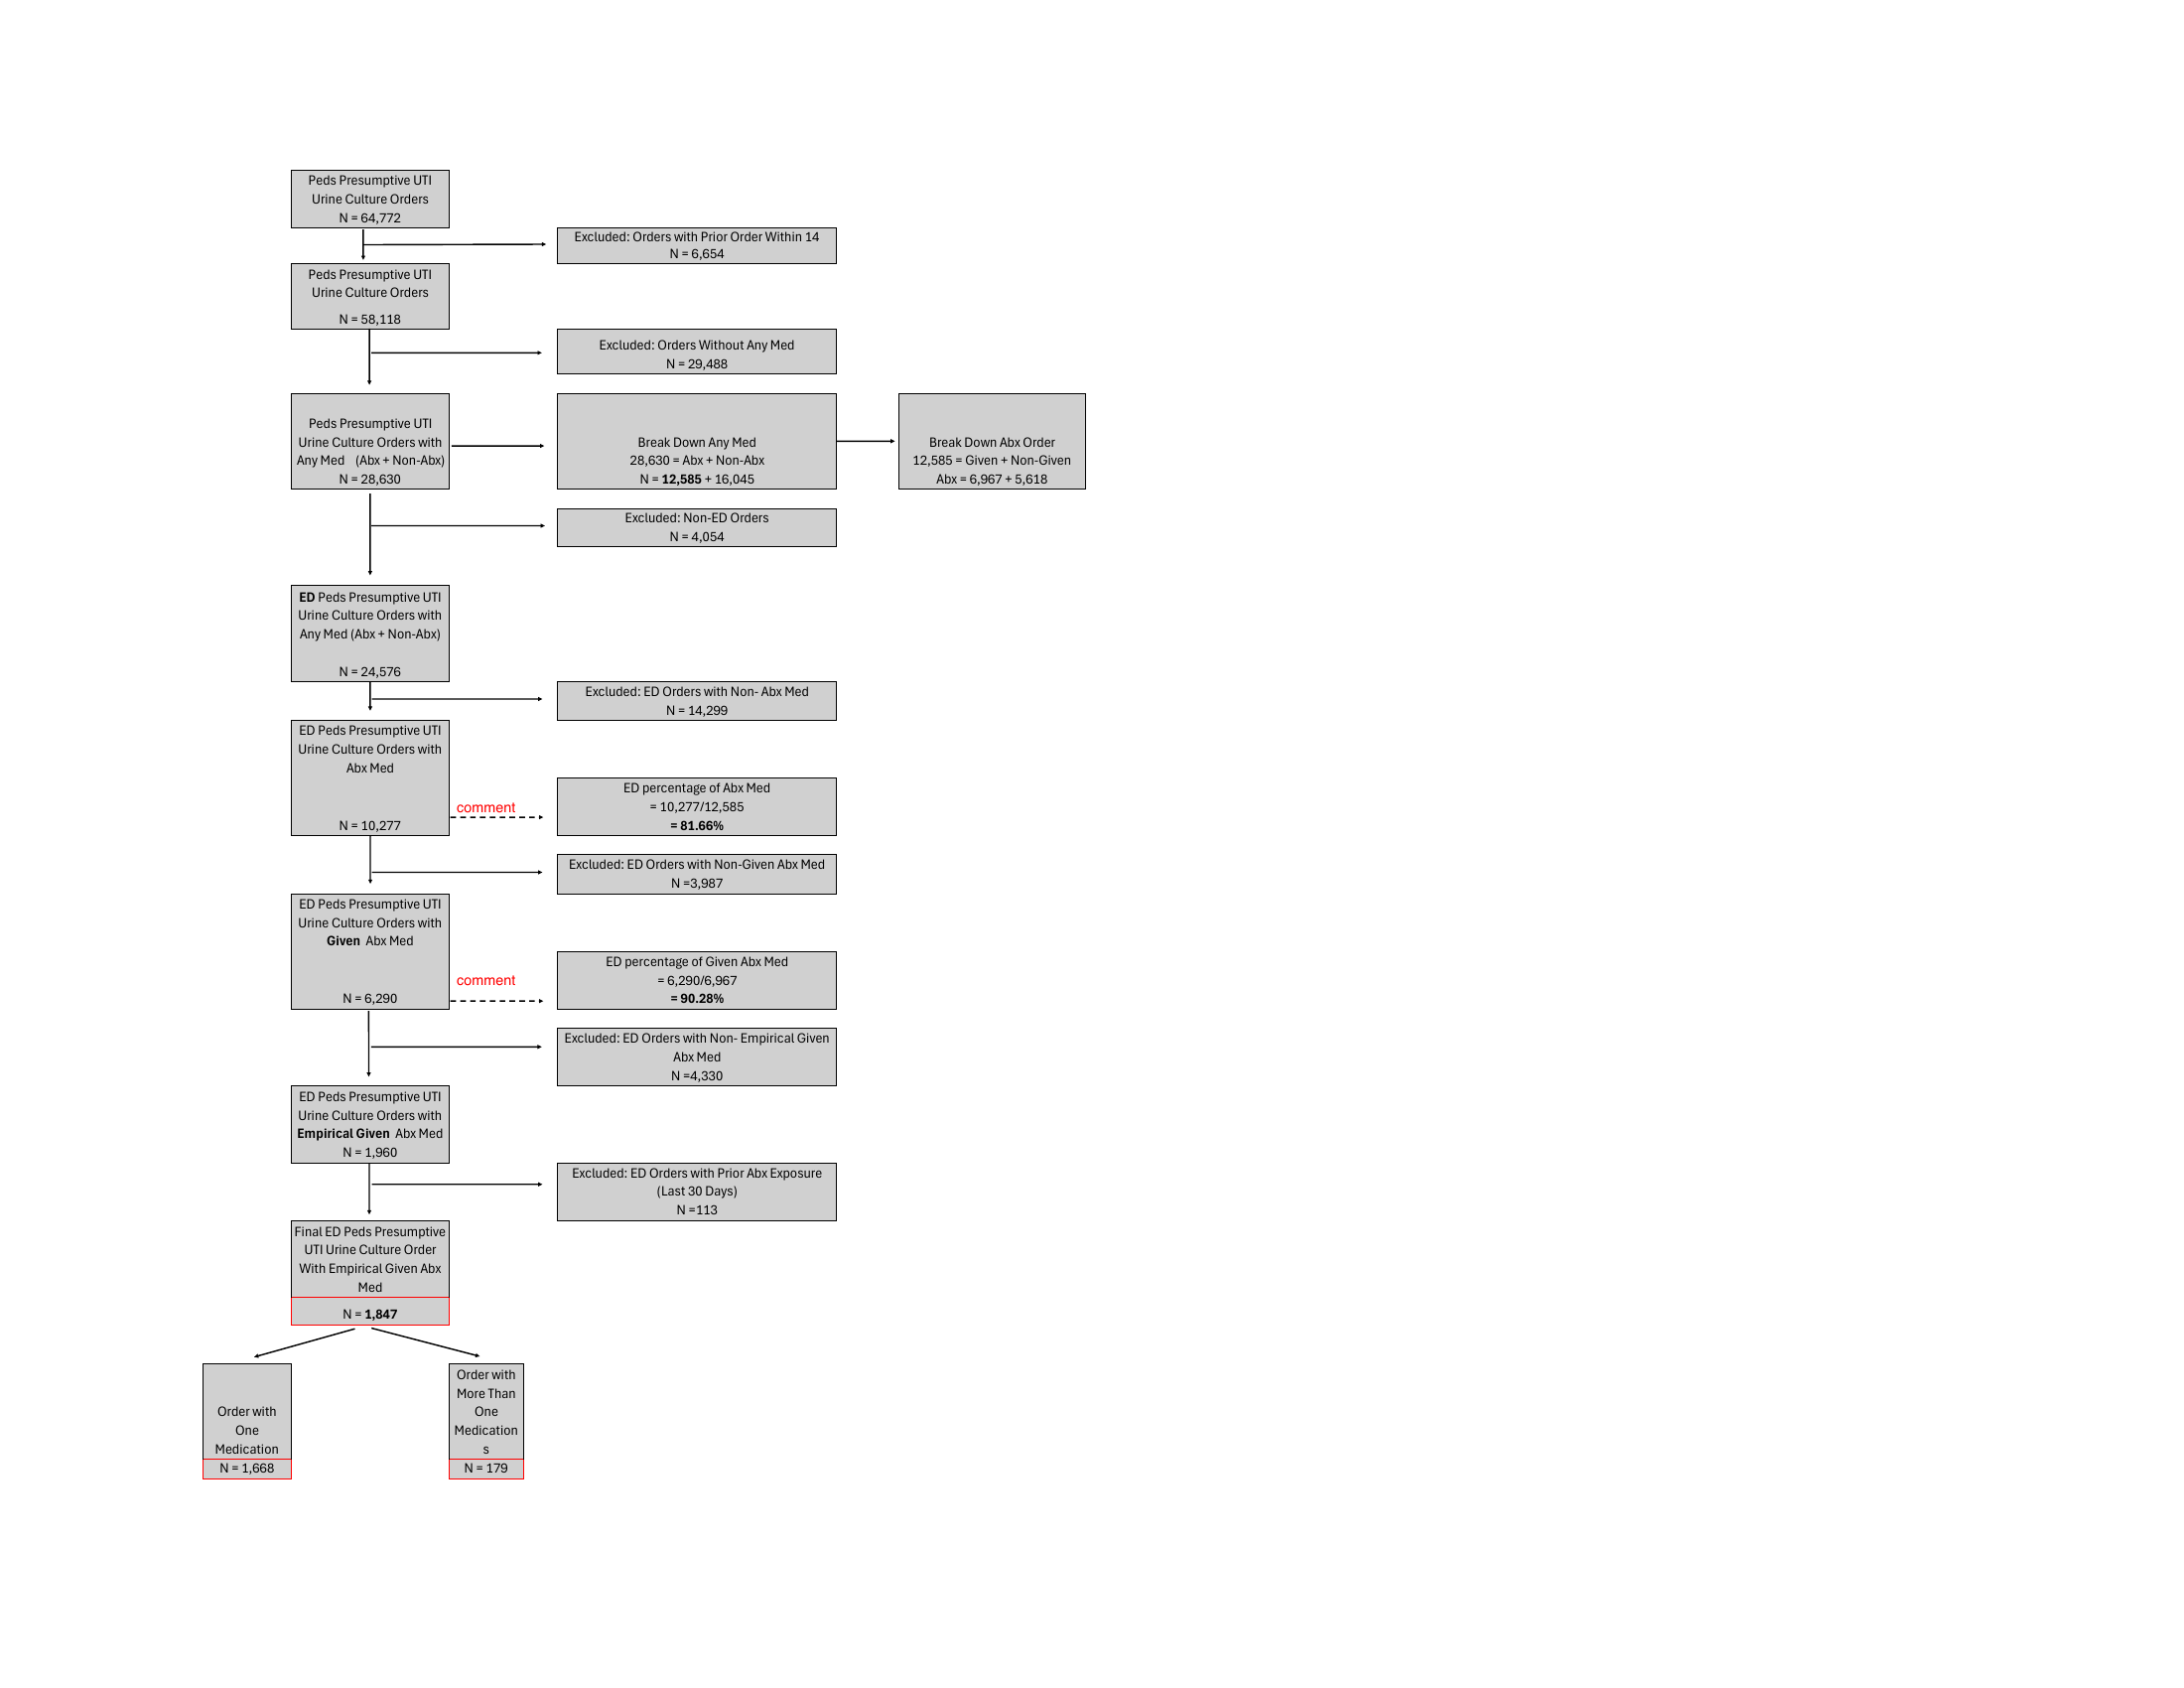

In [152]:
pages = convert_from_path('imgs/Aim_4_Flowchart_Custom_peds.pdf', dpi=200)
path_png = 'imgs/step6_peds.png'
pages[8].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))

In [138]:
import ast
def convert_to_list_and_keep_longest(value):
    # 1) Convert string -> list if possible
    if isinstance(value, str):
        try:
            value = ast.literal_eval(value)
        except:
            # If parsing fails, just keep the original value
            pass
    
    # 2) If the value is now a non-empty list, return the longest item
    if isinstance(value, list) and value:
        return max(value, key=len)
    
    # Otherwise, return the value as-is
    return value

# Apply the function to your column
final_cohort_peds["final_antibiotic"] = final_cohort_peds["cleaned_antibiotic"].apply(convert_to_list_and_keep_longest).replace(cleaning_mapping)

In [140]:
# This also brings up another problem: how do we actually want to evaluate appropriteness of medication prescription for one culture order.
# Nick could talk more about this
# Count number of rows per group
final_cohort_peds= final_cohort_peds.drop_duplicates(subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc', 'final_antibiotic'], keep='first', inplace=False)
group_counts = final_cohort_peds.groupby(
    ['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc']
)['final_antibiotic'].transform('count')

# Filter rows where group count is greater than 1
group_counts_df= final_cohort_peds[group_counts > 1]
sorted_group_counts_df = group_counts_df.sort_values(by=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])
# sorted_group_counts_df.head(50)
print("the unique order number for final_cohort is {}".format(find_unique_orders(final_cohort_peds)))
print("the unique order number from final cohort that has more than one medication is {}".format(find_unique_orders(sorted_group_counts_df)))

the unique order number for final_cohort is 1847
the unique order number from final cohort that has more than one medication is 160


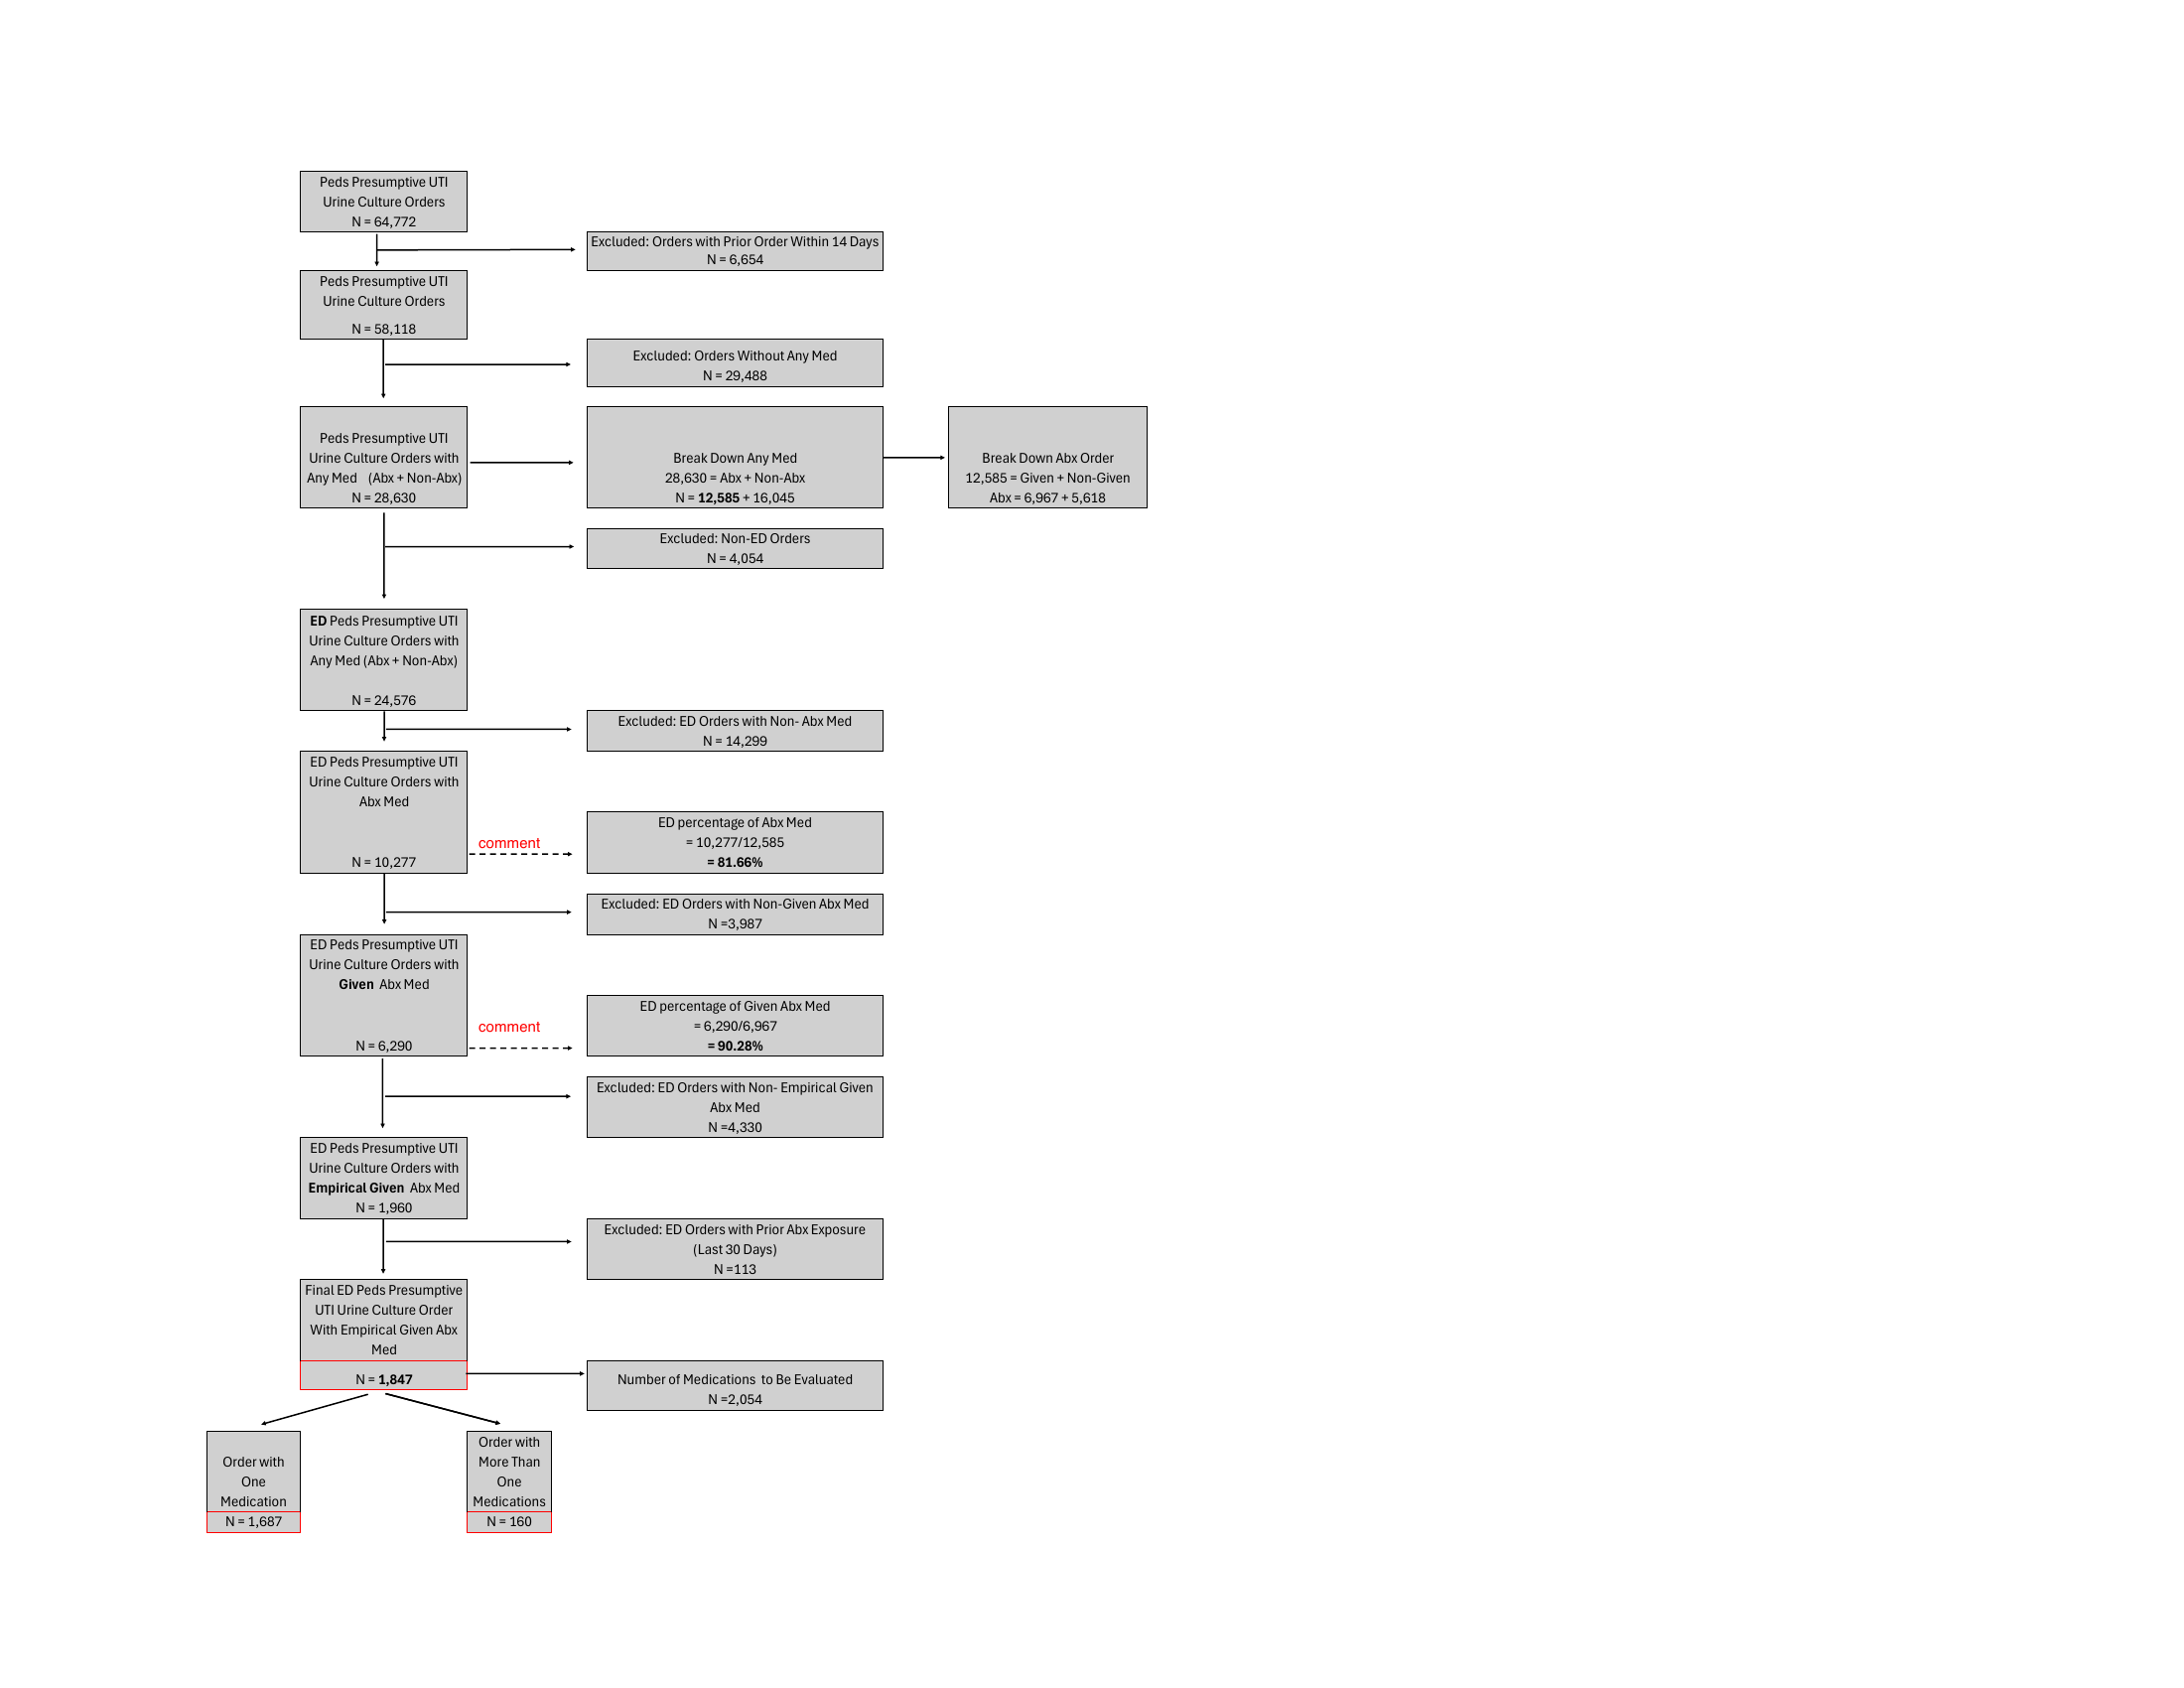

In [153]:
pages = convert_from_path('imgs/Aim_4_Flowchart_Custom_peds.pdf', dpi=200)
path_png = 'imgs/final_step_peds.png'
pages[9].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))

In [89]:
final_cohort_peds.to_csv('../csv_folder/final_peds_cohort.csv', index=False)

In [49]:
# read impliced_susceptibility rules
implied_suspectibility = pd.read_csv('../csv_folder/implied_susceptibility_rules.csv')

In [90]:
import re
with_implied_susceptibility_starting_cohort = peds_starting_cohort.copy()
with_implied_susceptibility_starting_cohort["susceptibility_source"] = "original"
# Get unique organisms from implied_susceptibility
bacteria = implied_suspectibility["Organism"].dropna().unique().tolist()

# Create regex pattern and find matches
pattern = '|'.join([re.escape(org) for org in bacteria])
matches = with_implied_susceptibility_starting_cohort["organism"].str.contains(pattern, case=False, na=False)

# Add a new column showing WHICH organism was matched
def find_matched_organism(org_name):
    org_name = str(org_name).upper()
    for bact in bacteria:
        if re.search(re.escape(bact), org_name, re.IGNORECASE):
            return bact
    return None

with_implied_susceptibility_starting_cohort['matched_organism'] \
    = with_implied_susceptibility_starting_cohort['organism'].apply(find_matched_organism)


In [91]:
# Step 2: Join with our starting cohort on matched organisms
inherent_resistance = implied_suspectibility[
    implied_suspectibility['Implied_Agent'].isna()
][['Organism', 'Antibiotic']].drop_duplicates()
resistant_to_add = pd.merge(
    with_implied_susceptibility_starting_cohort[['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded',
       'order_time_jittered_utc', 'result_time_jittered_utc', 'ordering_mode',
       'culture_description', 'was_positive', 'organism', "matched_organism"]].drop_duplicates(),
    inherent_resistance,
    left_on='matched_organism',
    right_on='Organism',
    how='inner'
)
resistant_to_add = resistant_to_add.rename(columns={'Antibiotic': 'antibiotic'})
resistant_to_add['susceptibility'] = 'Resistant'
resistant_to_add['susceptibility_source'] = 'inherent_resistance'
cols_to_keep = with_implied_susceptibility_starting_cohort.columns
added_resistant_cohort = (pd.concat([
    with_implied_susceptibility_starting_cohort,
    resistant_to_add[cols_to_keep]
], ignore_index=True))\
    .drop_duplicates(subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 
            'organism', 'antibiotic', 'susceptibility'], keep='first')\
    .sort_values(by=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])# Keeps our new resistant records if duplicates exist

In [92]:
# Step 1: Get cases where Implied_Agent exists (not null)
implied_agent_rules = implied_suspectibility[
    implied_suspectibility['Implied_Agent'].notna()
][['Organism', 'Antibiotic', 'Implied_Agent']].drop_duplicates()
implied_to_process = pd.merge(
    added_resistant_cohort.drop(columns = ['susceptibility_source']),
    implied_agent_rules,
    left_on=['matched_organism', 'antibiotic'],
    right_on=['Organism', 'Implied_Agent'],
    how='inner'
).rename(columns={'antibiotic': 'antibiotic_to_drop', 'Antibiotic': 'antibiotic'}).drop(columns =['antibiotic_to_drop', 'Organism', 'Implied_Agent'])
implied_to_process['susceptibility_source'] = 'implied'
cols_to_keep = added_resistant_cohort.columns
final_implied_cohort = (pd.concat([
    added_resistant_cohort,
    implied_to_process[cols_to_keep]
], ignore_index=True)).sort_values(by=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])\
    .drop_duplicates(subset=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 
            'organism', 'antibiotic', 'susceptibility'], keep='first')

In [94]:
final_implied_cohort.to_csv('../csv_folder/final_implied_peds_cohort.csv', index=False)

In [95]:
merged_culture_med = final_cohort_peds.drop(columns = ["cleaned_antibiotic"]).merge(final_implied_cohort, on=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc', 'result_time_jittered_utc'], how='inner')

In [97]:
merged_culture_med.to_csv('../csv_folder/merged_culture_med_analysis_peds.csv', index=False)

In [98]:
print("while the unique culture order is {}, the number of medication to evaluate is {}".format(find_unique_orders(final_cohort_peds), len(final_cohort_peds)))

while the unique culture order is 1847, the number of medication to evaluate is 2054


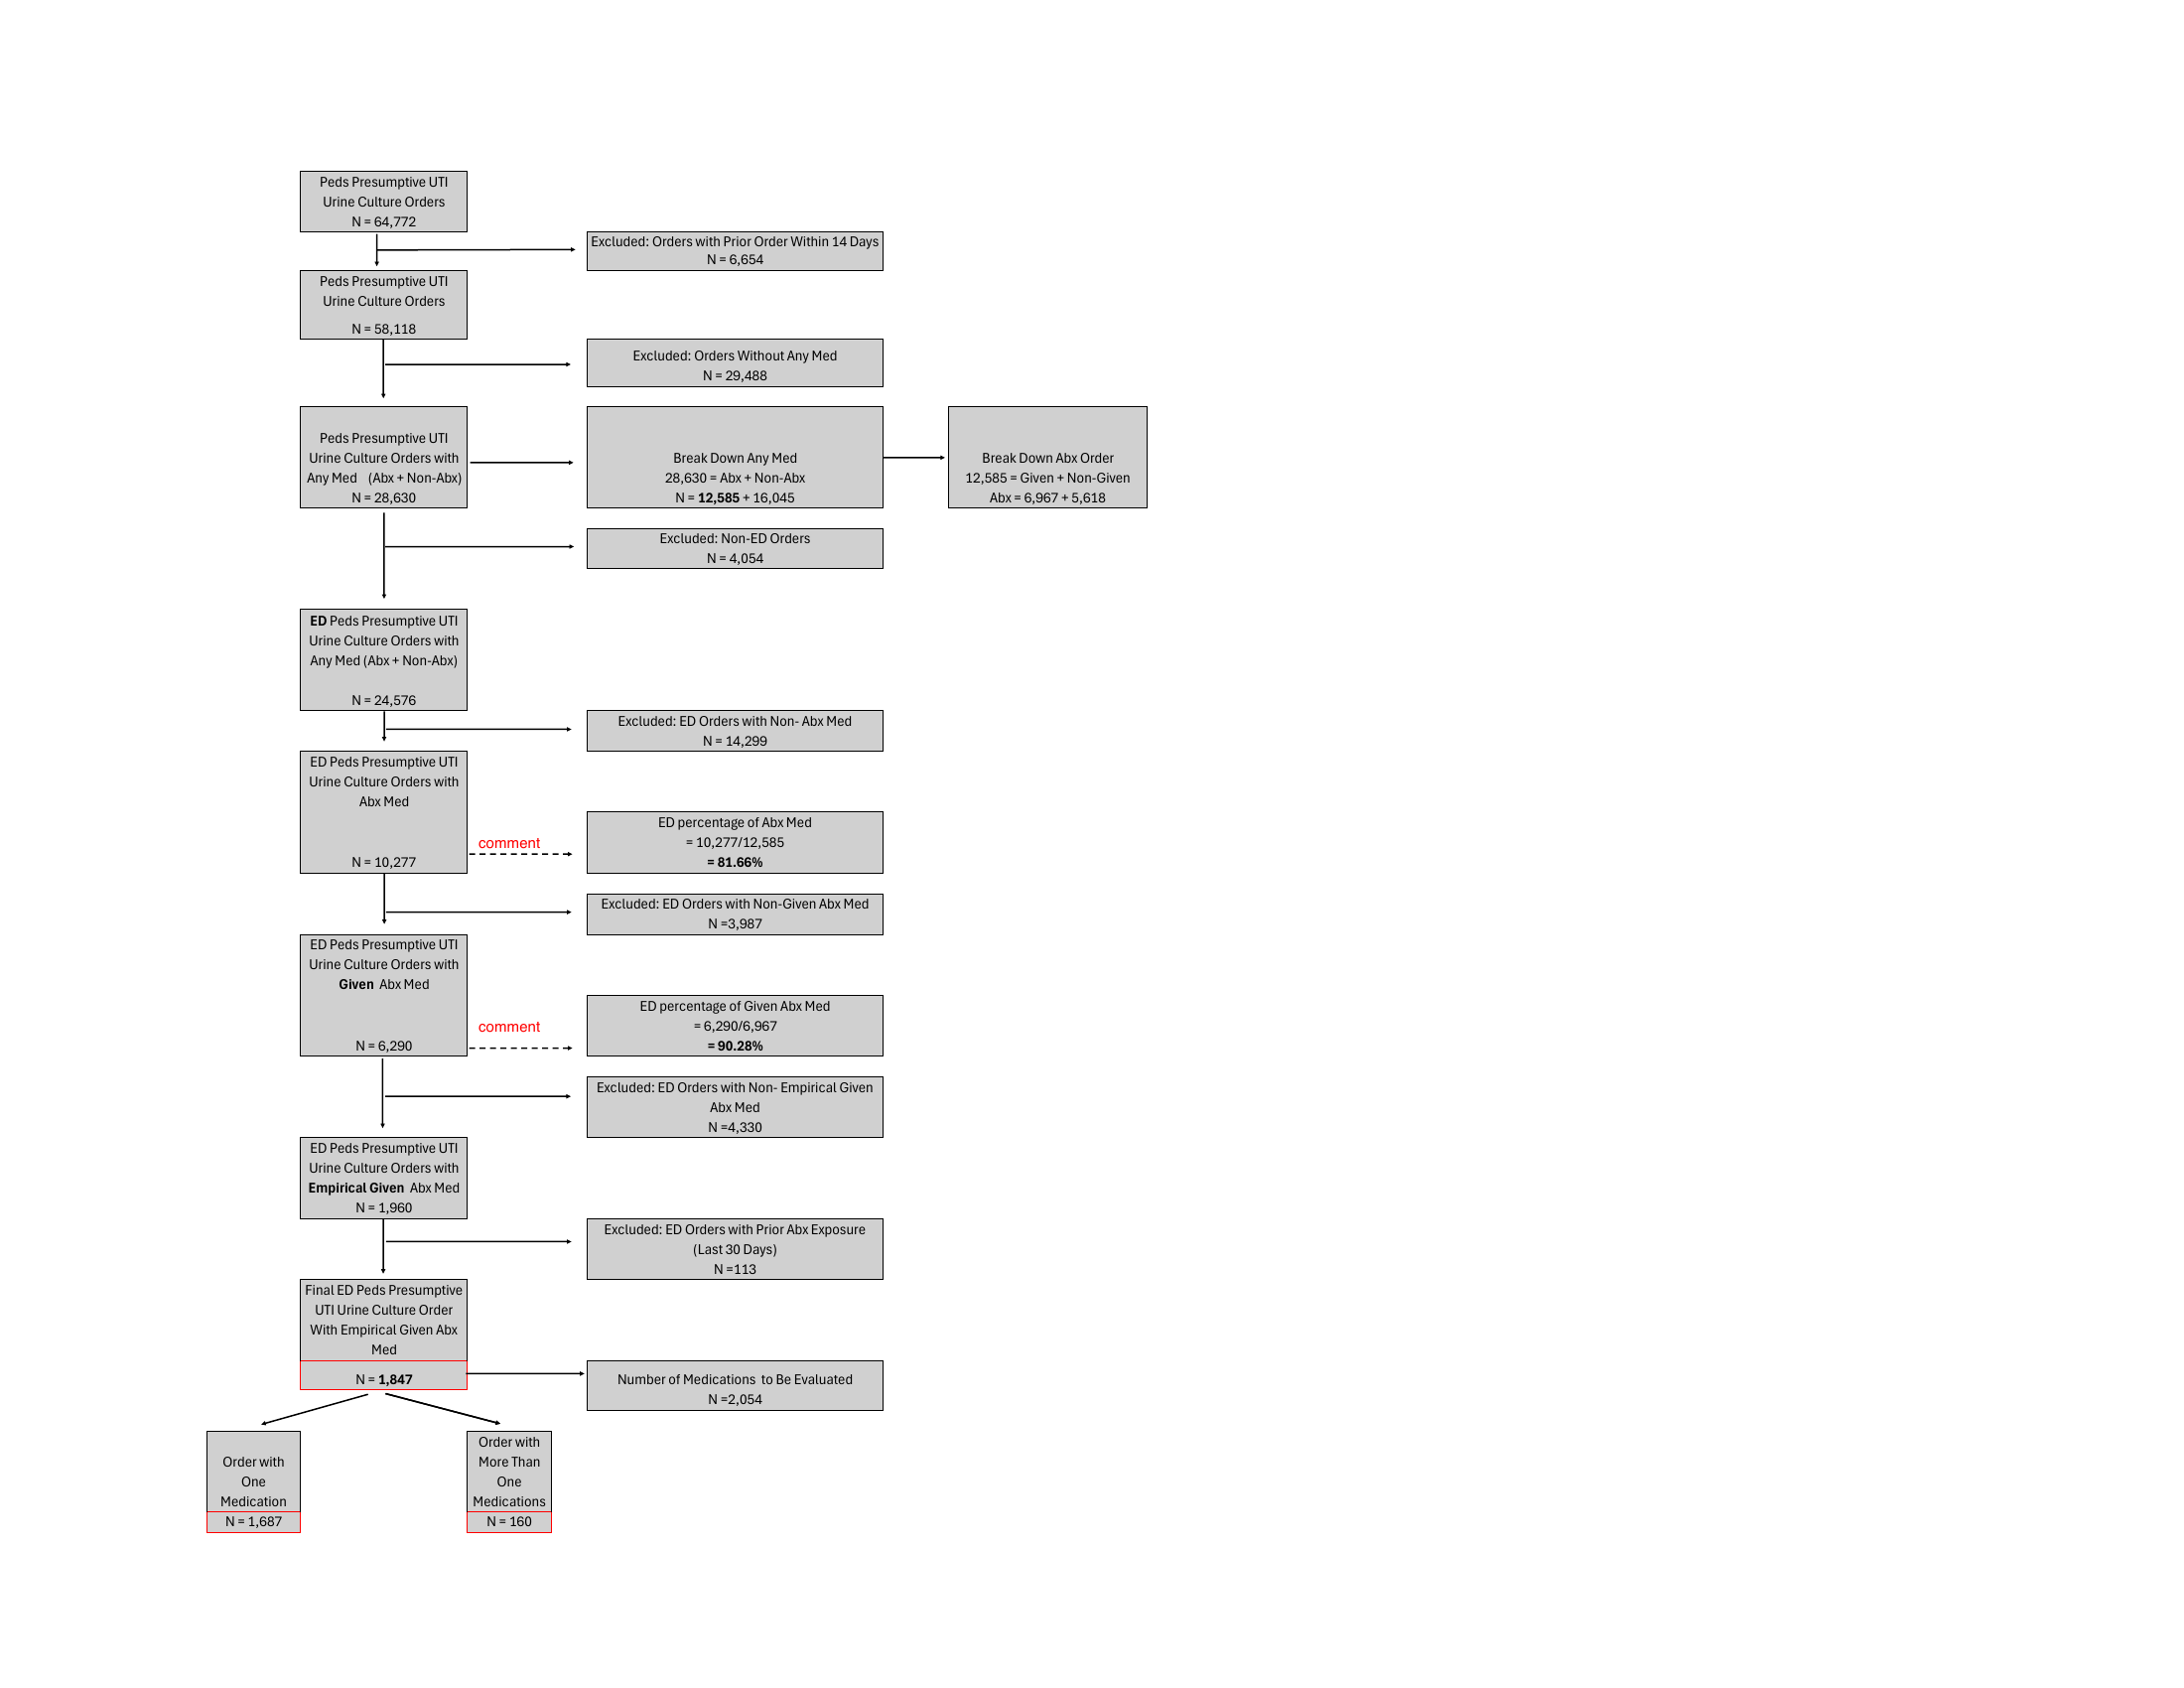

In [154]:
pages = convert_from_path('imgs/Aim_4_Flowchart_Custom_peds.pdf', dpi=200)
path_png = 'imgs/final_step_peds.png'
pages[9].save(path_png, 'PNG')
# Display the image in the notebook
display(Image(filename=path_png))

In [102]:
%%bigquery --use_rest_api aim_4_antibiotic_ranking
select * from som-nero-phi-jonc101.antimicrobial_stewardship_sandy_copy.aim_4_antibiotic_ranking

Query is running:   0%|          |

Downloading:   0%|          |

In [155]:
with_prescribed_abx_rank_df = merged_culture_med.merge(aim_4_antibiotic_ranking, \
                                   left_on=['final_antibiotic'], right_on=['antibiotic_agent'], how='left')\
                                    .rename(columns={'spectrum_ranking': 'presciribed_antibiotic_rank'})\
                                    .drop(columns = ['antibiotic_agent', 'spectrum'])
with_tested_and_prescribed_abx_rank_df = with_prescribed_abx_rank_df.merge(aim_4_antibiotic_ranking, \
                                   left_on=['antibiotic'], right_on=['antibiotic_agent'], how='left')\
                                    .rename(columns={'spectrum_ranking': 'tested_antibiotic_rank'})\
                                        .drop(columns = ['antibiotic_agent', 'spectrum'])

In [156]:
negative_cohort = with_tested_and_prescribed_abx_rank_df[with_tested_and_prescribed_abx_rank_df["was_positive"] == 0]
positive_cohort = with_tested_and_prescribed_abx_rank_df[with_tested_and_prescribed_abx_rank_df["was_positive"] == 1]

In [162]:
find_unique_orders(negative_cohort)
# This also brings up another problem: how do we actually want to evaluate appropriteness of medication prescription for one culture order.
# Nick could talk more about this
# Count number of rows per group
group_counts = negative_cohort.groupby(
    ['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc']
)['final_antibiotic'].transform('count')

# Filter rows where group count is greater than 1
group_counts_df= negative_cohort[group_counts > 1]
sorted_group_counts_df = group_counts_df.sort_values(by=['anon_id', 'pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc'])
# sorted_group_counts_df.head(50)
sorted_group_counts_df

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,medication_time,medication_name,order_med_id_coded,medication_action,final_antibiotic,ordering_mode,culture_description,was_positive,organism,antibiotic,susceptibility,susceptibility_source,matched_organism,presciribed_antibiotic_rank,tested_antibiotic_rank
0,JC1000924,131014644911,387581858,2011-07-25 05:14:00+00:00,2011-07-27 02:24:00+00:00,2011-07-25 07:00:00+00:00,CEPHALEXIN 250 MG PO CAPS,387591109.0,Given,Cephalexin/Cephalothin,Inpatient,URINE,0,None,None,None,original,None,1,<NA>
1,JC1000924,131014644911,387581858,2011-07-25 05:14:00+00:00,2011-07-27 02:24:00+00:00,2011-07-25 07:00:00+00:00,SULFAMETHOXAZOLE-TRIMETHOPRIM 400-80 MG PO TABS,387591245.0,Given,Trimethoprim/Sulfamethoxazole,Inpatient,URINE,0,None,None,None,original,None,2,<NA>
55,JC1009787,131019502504,403504799,2012-07-19 02:49:00+00:00,2012-07-21 16:12:00+00:00,2012-07-19 07:00:00+00:00,CEFTRIAXONE PEDIATRIC IV INFUSION,403518155.0,Given,Ceftriaxone,Inpatient,URINE,0,None,None,None,original,None,3,<NA>
56,JC1009787,131019502504,403504799,2012-07-19 02:49:00+00:00,2012-07-21 16:12:00+00:00,2012-07-19 07:00:00+00:00,VANCOMYCIN PEDIATRIC IV INFUSION,403518554.0,Given,Vancomycin,Inpatient,URINE,0,None,None,None,original,None,5,<NA>
214,JC1054889,131020147678,405541285,2012-09-10 09:20:00+00:00,2012-09-12 15:14:00+00:00,2012-09-10 07:00:00+00:00,CEFTRIAXONE PEDIATRIC IM INJECTION,405542350.0,Given,Ceftriaxone,Inpatient,URINE,0,None,None,None,original,None,3,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13044,JC5260476,131364580820,913104099,2023-09-22 11:49:00+00:00,2023-09-24 16:33:00+00:00,2023-09-22 07:00:00+00:00,CEFTRIAXONE 2 GRAM/20 ML IV PUSH (VIAL ONLY),913105255.0,Given,Ceftriaxone,Inpatient,URINE,0,None,None,None,original,None,3,<NA>
14029,JC975867,131029432861,433587832,2013-12-30 05:14:00+00:00,2014-01-01 16:29:00+00:00,2013-12-30 08:00:00+00:00,MEROPENEM IVPB,433602528.0,Given,Meropenem,Inpatient,URINE,0,None,None,None,original,None,5,<NA>
14030,JC975867,131029432861,433587832,2013-12-30 05:14:00+00:00,2014-01-01 16:29:00+00:00,2013-12-30 08:00:00+00:00,VANCOMYCIN PEDIATRIC IV INFUSION,433602534.0,Given,Vancomycin,Inpatient,URINE,0,None,None,None,original,None,5,<NA>
14047,JC977071,131243318147,546794293,2017-12-25 07:53:00+00:00,2017-12-27 18:47:00+00:00,2017-12-25 08:00:00+00:00,CEFTRIAXONE PEDIATRIC IV INFUSION,546804446.0,Given,Ceftriaxone,Inpatient,URINE,0,None,None,None,original,None,3,<NA>


In [163]:
# negative rate
1310/2054, 744/2054

(0.6377799415774099, 0.3622200584225901)

In [119]:
2054 - 1310

744

In [68]:
# negative_cohort["final_antibiotic"].value_counts().sort_index()
positive_cohort["tested_antibiotic_rank"].value_counts().sort_index()

tested_antibiotic_rank
1    1443
2    3927
3    4782
4    1174
5    1143
6     140
Name: count, dtype: Int64

In [164]:
def evaluate_antibiotic_appropriateness(group):
    # Get all tested antibiotics with their susceptibility and ranking
    tested_abx = group[['antibiotic', 'susceptibility', 'tested_antibiotic_rank']].drop_duplicates()
    
    # Get the prescribed antibiotic
    prescribed_abx = group['final_antibiotic'].iloc[0]
    prescribed_rank = group['presciribed_antibiotic_rank'].iloc[0]
    
    # Scenario 1: Appropriate (susceptible and minimal rank)
    susceptible_tested = tested_abx[tested_abx['susceptibility'] == 'Susceptible']
    if not susceptible_tested.empty:
        min_rank = susceptible_tested['tested_antibiotic_rank'].min()
        if prescribed_abx in susceptible_tested['antibiotic'].values:
            if prescribed_rank == min_rank:
                return pd.Series({
                    'scenario': 'appropriate',
                    'ranking_diff': 0,
                    'min_susceptible_test_rank': min_rank,
                    'prescribed_rank': prescribed_rank
                })
    
    # Scenario 2: Too broad (susceptible but not minimal rank)
            else:
                return pd.Series({
                    'scenario': 'too_broad',
                    'ranking_diff': prescribed_rank - min_rank,
                    'min_susceptible_test_rank': min_rank,
                    'prescribed_rank': prescribed_rank
                })
    
    # Scenario 3: Resistant (non-susceptible)
    if prescribed_abx in group['antibiotic'].values:
        prescribed_susceptibility = group[group['antibiotic'] == prescribed_abx]['susceptibility'].iloc[0]
        if prescribed_susceptibility != 'Susceptible':
            return pd.Series({
                'scenario': 'resistant',
                'ranking_diff': None,
                'min_susceptible_test_rank': susceptible_tested['tested_antibiotic_rank'].min() if not susceptible_tested.empty else None,
                'prescribed_rank': prescribed_rank
            })
    
    # Scenario 4: Not performed
    return pd.Series({
        'scenario': 'not_performed',
        'ranking_diff': None,
        'min_susceptible_test_rank': susceptible_tested['tested_antibiotic_rank'].min() if not susceptible_tested.empty else None,
        'prescribed_rank': prescribed_rank
    })

# Apply to each group
results = positive_cohort.groupby([
    "anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded", 
    "order_time_jittered_utc", "result_time_jittered_utc", "final_antibiotic"
]).apply(evaluate_antibiotic_appropriateness).reset_index()

# Merge results back with original data
final_cohort_with_evaluation = positive_cohort.merge(
    results,
    on=["anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded", 
        "order_time_jittered_utc", "result_time_jittered_utc", "final_antibiotic"]
)
final_cohort_with_evaluation.drop(columns = ['medication_action', 'ordering_mode', 'culture_description','order_med_id_coded'], inplace=True)

In [179]:
results.to_csv('../csv_folder/antibiotic_appropriateness_peds.csv', index=False)

In [165]:
results["scenario"].value_counts()

scenario
not_performed    417
too_broad        204
resistant         62
appropriate       53
Name: count, dtype: int64

In [112]:
results

,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,final_antibiotic,scenario,ranking_diff,min_susceptible_test_rank,prescribed_rank
0,JC1001971,131011493486,375107375,2010-10-28 06:49:00+00:00,2010-10-30 05:01:00+00:00,Trimethoprim/Sulfamethoxazole,too_broad,1.0,1,2
1,JC1005241,131016754242,394189928,2012-01-17 10:45:00+00:00,2012-01-19 19:00:00+00:00,Ceftriaxone,not_performed,NaN,1,3
2,JC1005241,131019804362,404483566,2012-08-09 05:10:00+00:00,2012-08-11 19:24:00+00:00,Ceftriaxone,not_performed,NaN,1,3
3,JC1008884,131234433374,528615030,2017-05-22 08:46:00+00:00,2017-05-24 18:28:00+00:00,Ceftriaxone,too_broad,2.0,1,3
4,JC1011107,131299183988,694740212,2020-12-06 10:33:00+00:00,2020-12-08 16:31:00+00:00,Cephalexin/Cephalothin,not_performed,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...
731,JC992265,131212198910,513817275,2016-12-26 12:40:00+00:00,2017-01-10 23:27:00+00:00,Cefepime,not_performed,NaN,2,4
732,JC992265,131223689596,521468039,2017-03-21 05:06:00+00:00,2017-03-23 22:48:00+00:00,Ciprofloxacin,too_broad,2.0,1,3
733,JC992265,131281206612,645404732,2019-12-23 09:37:00+00:00,2019-12-25 17:47:00+00:00,Ceftriaxone,too_broad,2.0,1,3
734,JC992265,131294446733,681722202,2020-09-03 05:15:00+00:00,2020-09-06 22:13:00+00:00,Ciprofloxacin,too_broad,1.0,2,3


In [107]:
results["scenario"].value_counts()

scenario
not_performed    417
too_broad        204
resistant         62
appropriate       53
Name: count, dtype: int64

In [198]:
import random
grouped = final_cohort_with_evaluation[final_cohort_with_evaluation["scenario"] == "not_performed"].groupby([
    "anon_id", "pat_enc_csn_id_coded", "order_proc_id_coded", 
    "order_time_jittered_utc", "result_time_jittered_utc", "final_antibiotic"
])
# Randomly pick a group
random_group = random.choice(list(grouped.groups.keys()))
print(f"Randomly picked group: {random_group}")
# Build a boolean filter from the group key
filt = (
    (final_cohort_with_evaluation["anon_id"] == random_group[0]) &
    (final_cohort_with_evaluation["pat_enc_csn_id_coded"] == random_group[1]) &
    (final_cohort_with_evaluation["order_proc_id_coded"] == random_group[2]) &
    (final_cohort_with_evaluation["order_time_jittered_utc"] == random_group[3]) &
    (final_cohort_with_evaluation["result_time_jittered_utc"] == random_group[4]) &
    (final_cohort_with_evaluation["final_antibiotic"] == random_group[5])
)
final_cohort_with_evaluation[filt]


Randomly picked group: ('JC2397252', 131265802808, 602821381, Timestamp('2019-03-27 06:48:00+0000', tz='UTC'), Timestamp('2019-03-29 22:29:00+0000', tz='UTC'), 'Amoxicillin')


,anon_id,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,result_time_jittered_utc,medication_time,medication_name,final_antibiotic,was_positive,organism,antibiotic,susceptibility,susceptibility_source,matched_organism,presciribed_antibiotic_rank,tested_antibiotic_rank,scenario,ranking_diff,min_susceptible_test_rank,prescribed_rank
8892,JC2397252,131265802808,602821381,2019-03-27 06:48:00+00:00,2019-03-29 22:29:00+00:00,2019-03-27 07:00:00+00:00,AMOXICILLIN 400 MG/5 ML PO SUSR,Amoxicillin,1,ENTEROCOCCUS SPECIES,Daptomycin,Susceptible,original,None,1,6,not_performed,NaN,1,1
8893,JC2397252,131265802808,602821381,2019-03-27 06:48:00+00:00,2019-03-29 22:29:00+00:00,2019-03-27 07:00:00+00:00,AMOXICILLIN 400 MG/5 ML PO SUSR,Amoxicillin,1,ENTEROCOCCUS SPECIES,Ampicillin,Susceptible,original,None,1,1,not_performed,NaN,1,1
8894,JC2397252,131265802808,602821381,2019-03-27 06:48:00+00:00,2019-03-29 22:29:00+00:00,2019-03-27 07:00:00+00:00,AMOXICILLIN 400 MG/5 ML PO SUSR,Amoxicillin,1,ENTEROCOCCUS SPECIES,Tetracycline,Susceptible,original,None,1,2,not_performed,NaN,1,1
8895,JC2397252,131265802808,602821381,2019-03-27 06:48:00+00:00,2019-03-29 22:29:00+00:00,2019-03-27 07:00:00+00:00,AMOXICILLIN 400 MG/5 ML PO SUSR,Amoxicillin,1,ENTEROCOCCUS SPECIES,Nitrofurantoin,Susceptible,original,None,1,2,not_performed,NaN,1,1
8896,JC2397252,131265802808,602821381,2019-03-27 06:48:00+00:00,2019-03-29 22:29:00+00:00,2019-03-27 07:00:00+00:00,AMOXICILLIN 400 MG/5 ML PO SUSR,Amoxicillin,1,ENTEROCOCCUS SPECIES,Linezolid,Susceptible,original,None,1,6,not_performed,NaN,1,1
8897,JC2397252,131265802808,602821381,2019-03-27 06:48:00+00:00,2019-03-29 22:29:00+00:00,2019-03-27 07:00:00+00:00,AMOXICILLIN 400 MG/5 ML PO SUSR,Amoxicillin,1,ENTEROCOCCUS SPECIES,Vancomycin,Susceptible,original,None,1,5,not_performed,NaN,1,1
8898,JC2397252,131265802808,602821381,2019-03-27 06:48:00+00:00,2019-03-29 22:29:00+00:00,2019-03-27 07:00:00+00:00,AMOXICILLIN 400 MG/5 ML PO SUSR,Amoxicillin,1,ENTEROCOCCUS SPECIES,Levofloxacin,Susceptible,original,None,1,3,not_performed,NaN,1,1
8899,JC2397252,131265802808,602821381,2019-03-27 06:48:00+00:00,2019-03-29 22:29:00+00:00,2019-03-27 07:00:00+00:00,AMOXICILLIN 400 MG/5 ML PO SUSR,Amoxicillin,1,ENTEROCOCCUS SPECIES,Ciprofloxacin,Susceptible,original,None,1,3,not_performed,NaN,1,1
8900,JC2397252,131265802808,602821381,2019-03-27 06:48:00+00:00,2019-03-29 22:29:00+00:00,2019-03-27 07:00:00+00:00,AMOXICILLIN 400 MG/5 ML PO SUSR,Amoxicillin,1,ENTEROCOCCUS SPECIES,Penicillin,Susceptible,original,None,1,1,not_performed,NaN,1,1


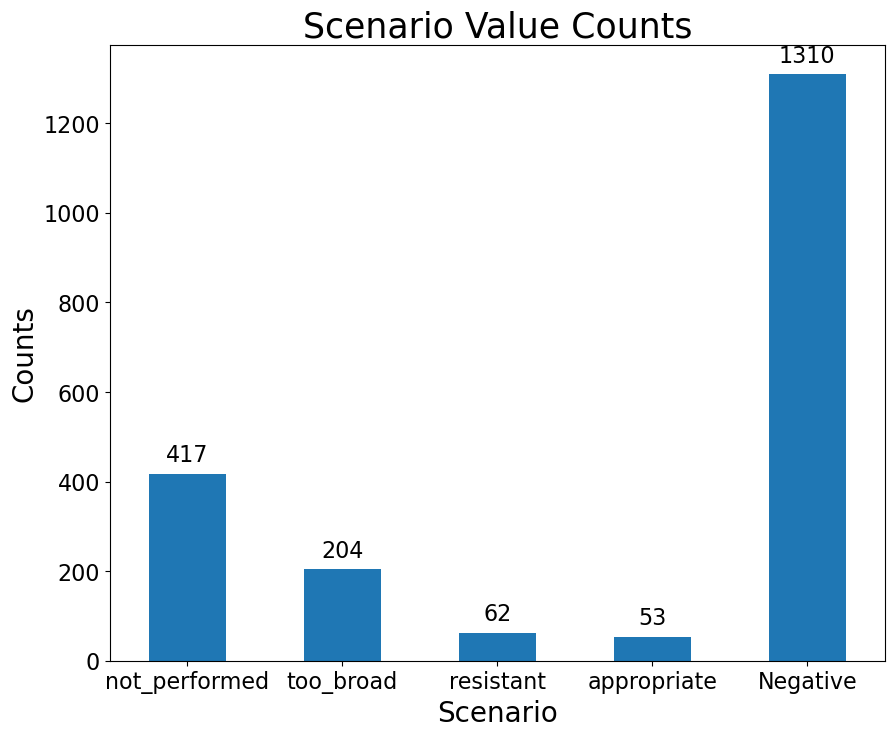

In [171]:
plt.figure(figsize=(10, 8))
# 1) Get the scenario counts as a Series
scenario_counts = results["scenario"].value_counts()

# 2) Append your extra row
scenario_counts.loc["Negative"] = 1310  # or scenario_counts["Extra Bar"] = 1310

# 3) Plot in one step
ax = scenario_counts.plot(
    kind='bar',
    title='Scenario Value Counts',
    xlabel='Scenario',
    ylabel='Counts',
    rot=0,  # rotate x-labels if desired
    fontsize=16, # increase the font size for labels
)
ax.set_title('Scenario Value Counts', fontsize=25)
ax.set_xlabel("Scenario", fontsize=20)
ax.set_ylabel("Counts", fontsize=20)
# Add count numbers on top of each bar
for i, count in enumerate(scenario_counts):
    ax.text(i, count + 16, str(count), ha='center', va='bottom', fontsize=16)

plt.show()

/var/folders/r3/mc640yrn2_70d_7zvw5cc3q00000gn/T/ipykernel_8640/2274030233.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage = scenario_percentages[i]


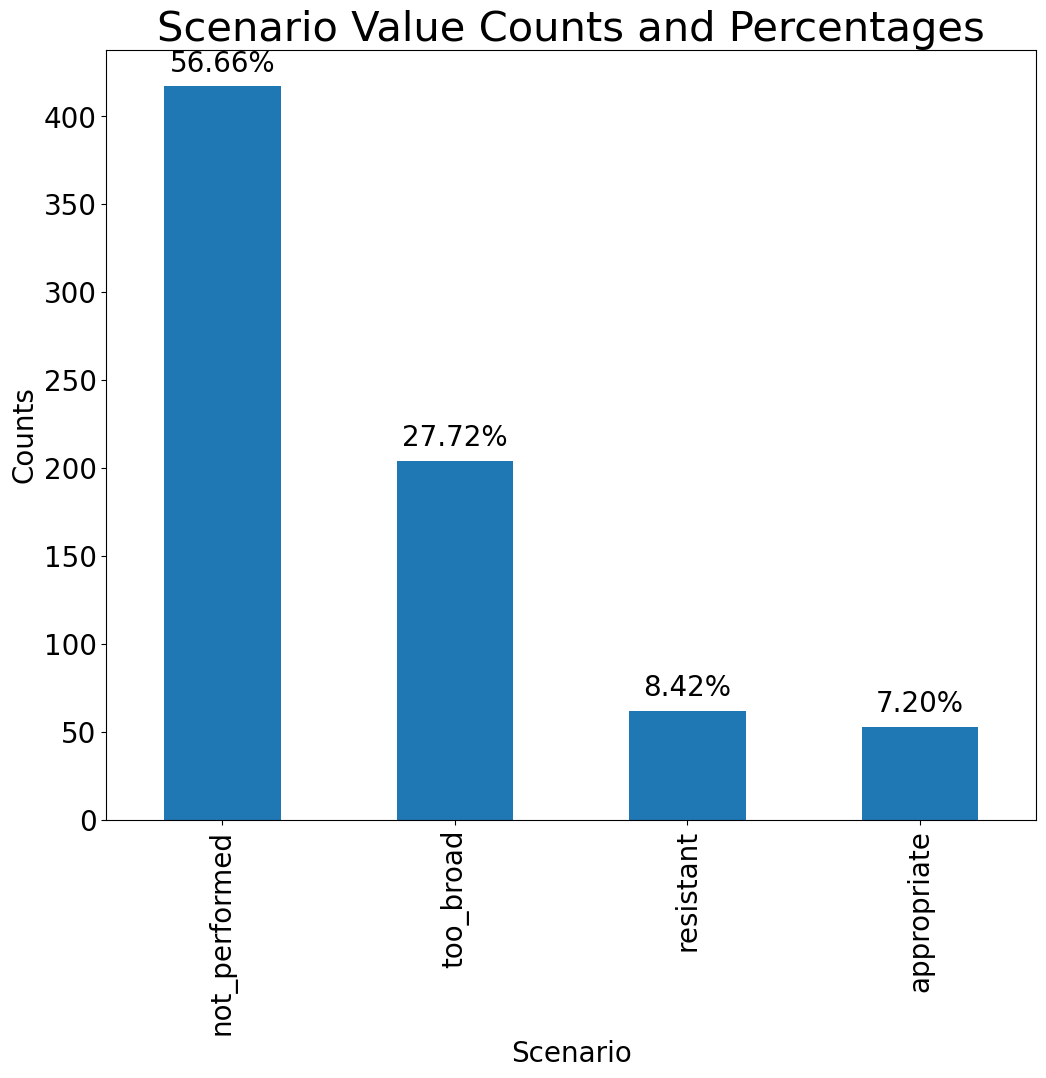

In [174]:
plt.figure(figsize=(12, 10))
# Plot the existing scenario value counts
# Calculate the percentage
scenario_counts = results["scenario"].value_counts()
scenario_percentages = (scenario_counts / scenario_counts.sum()) * 100

# Plot the counts
ax = scenario_counts.plot(kind='bar', title='Scenario Value Counts and Percentages', xlabel='Scenario', ylabel='Counts', fontsize=20)
ax.set_title('Scenario Value Counts and Percentages', fontsize=30)
ax.set_xlabel("Scenario", fontsize=20)
ax.set_ylabel("Counts", fontsize=20)
# Add percentages on top of the bars
for i, count in enumerate(scenario_counts):
    percentage = scenario_percentages[i]
    ax.text(i, count + 5, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=20)
# ax = results["scenario"].value_counts().plot(kind='bar', title='Scenario Value Counts', xlabel='Scenario', ylabel='Counts')


# Show the plot
plt.show()

In [175]:
results[results["scenario"] == "too_broad"]["ranking_diff"].value_counts().sort_index()

ranking_diff
1.0     62
2.0    131
3.0     10
4.0      1
Name: count, dtype: int64

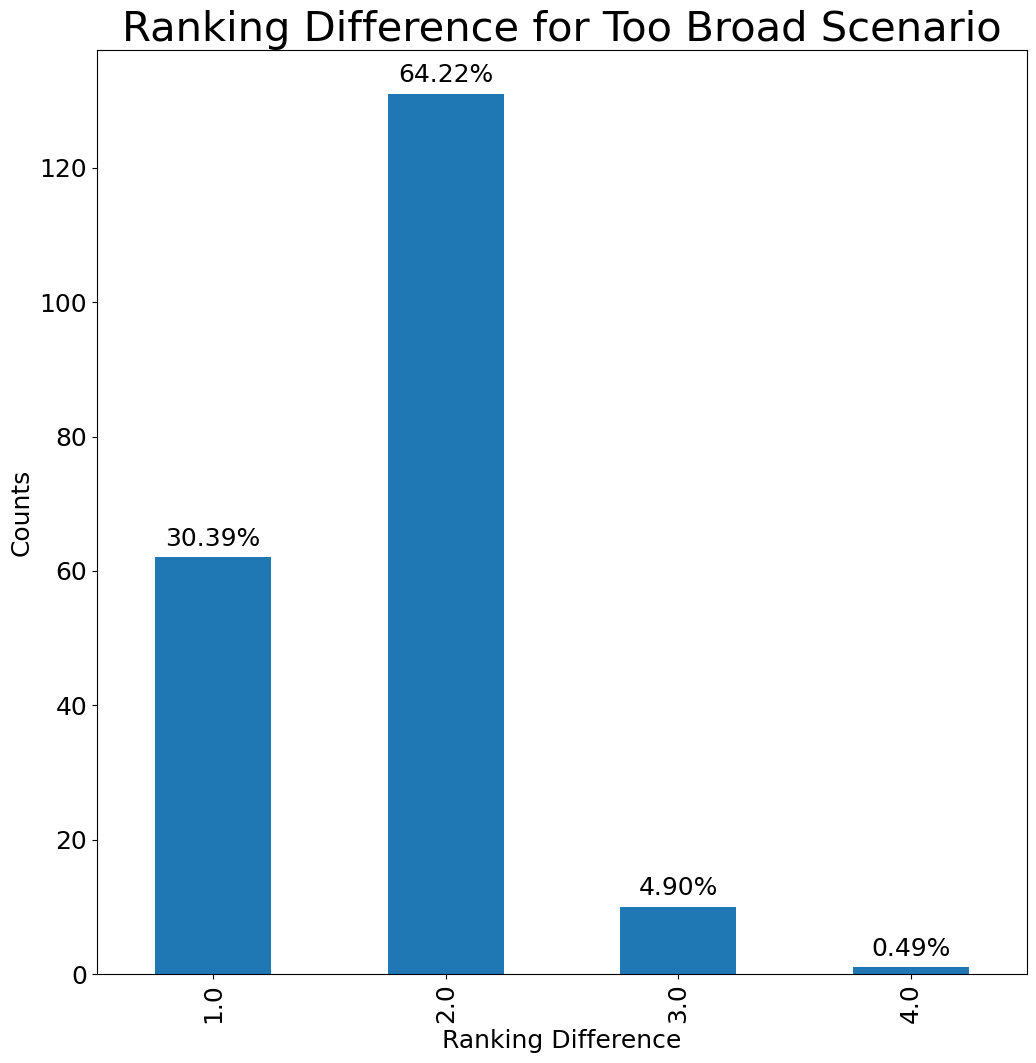

In [178]:
plt.figure(figsize=(12, 12))
ranking_diff_counts = results[results["scenario"] == "too_broad"]["ranking_diff"].value_counts().sort_index()

# Calculate the percentage
ranking_diff_percentages = (ranking_diff_counts / ranking_diff_counts.sum()) * 100

# Plot the counts
ax = ranking_diff_counts.plot(kind='bar', title='Ranking Difference for Too Broad Scenario', fontsize=18)
ax.set_title('Ranking Difference for Too Broad Scenario', fontsize=30)
ax.set_xlabel("Ranking Difference", fontsize=18)
ax.set_ylabel("Counts", fontsize=18)

# Add percentages on top of the bars
for i, count in enumerate(ranking_diff_counts):
    percentage = ranking_diff_percentages[i+1]
    ax.text(i, count + 1, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=18)
plt.show()
# ranking_diff_counts = results[results["scenario"] == "too_broad"]["ranking_diff"].value_counts().sort_index()
# ax = ranking_diff_counts.plot(kind='bar', title='Ranking Difference for Too Broad Scenario', xlabel='Ranking Difference', ylabel='Counts')


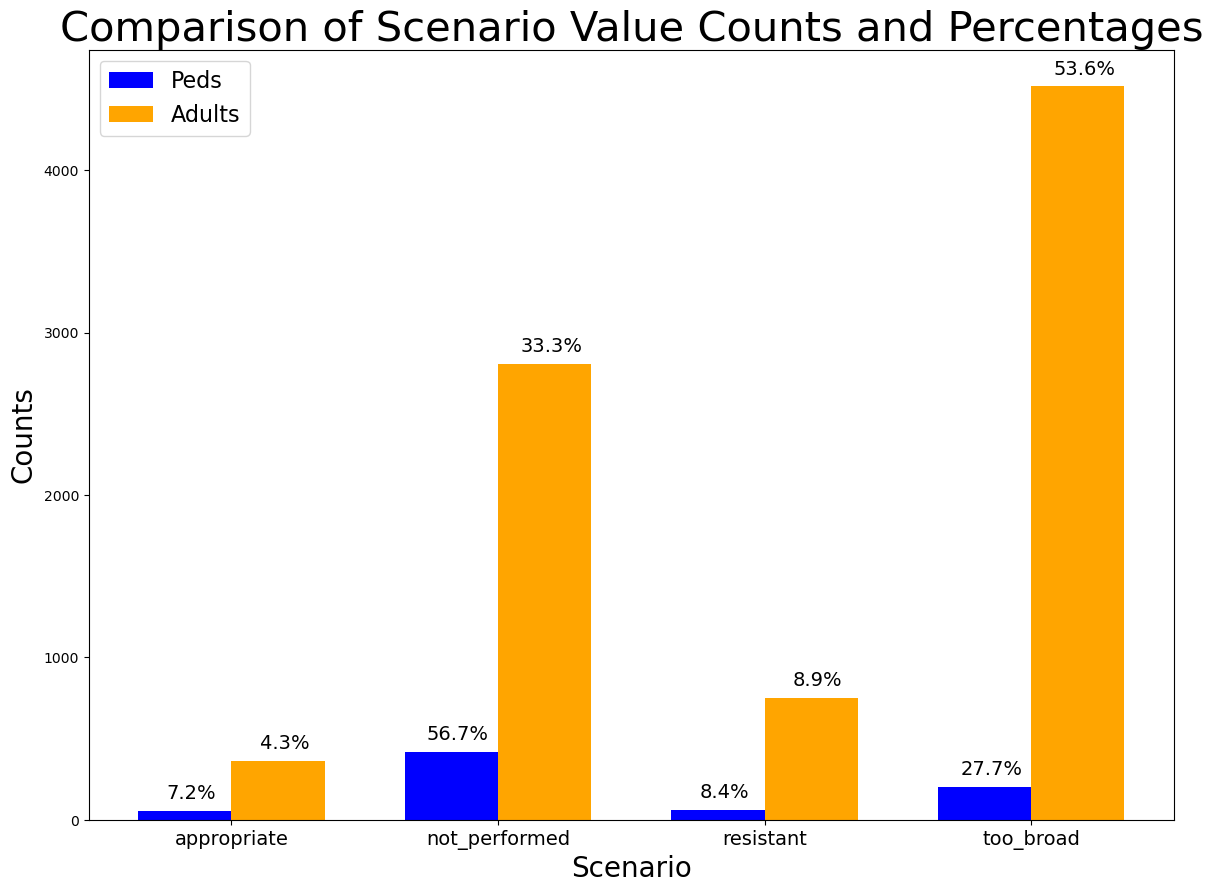

In [195]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your two CSV files
df1 = pd.read_csv('../csv_folder/antibiotic_appropriateness_peds.csv')  # Replace with your first file
df2 = pd.read_csv('../csv_folder/antibiotic_appropriateness.csv')  # Replace with your second file

# Calculate value counts and percentages for both dataframes
scenario_counts1 = df1["scenario"].value_counts().sort_index()
scenario_percentages1 = (scenario_counts1 / scenario_counts1.sum()) * 100

scenario_counts2 = df2["scenario"].value_counts().sort_index()
scenario_percentages2 = (scenario_counts2 / scenario_counts2.sum()) * 100

# Make sure both dataframes have the same scenarios (fill with 0 if missing)
all_scenarios = list(set(scenario_counts1.index).union(set(scenario_counts2.index)))
scenario_counts1 = scenario_counts1.reindex(all_scenarios, fill_value=0)
scenario_counts2 = scenario_counts2.reindex(all_scenarios, fill_value=0)
scenario_percentages1 = scenario_percentages1.reindex(all_scenarios, fill_value=0)
scenario_percentages2 = scenario_percentages2.reindex(all_scenarios, fill_value=0)

# Set up the plot
plt.figure(figsize=(14, 10))
ax = plt.gca()

# Set the width of each bar
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = range(len(all_scenarios))
r2 = [x + bar_width for x in r1]

# Plot the bars
bars1 = ax.bar(r1, scenario_counts1, width=bar_width, color='b', label='Peds')
bars2 = ax.bar(r2, scenario_counts2, width=bar_width, color='orange', label='Adults')

# Add percentages on top of the bars
for i, (count1, count2, pct1, pct2) in enumerate(zip(scenario_counts1, scenario_counts2, 
                                                    scenario_percentages1, scenario_percentages2)):
    ax.text(i - bar_width/2 + 0.2, count1 + 50, f'{pct1:.1f}%', ha='center', va='bottom', fontsize=14)
    ax.text(i + bar_width/2 + 0.2, count2 + 50, f'{pct2:.1f}%', ha='center', va='bottom', fontsize=14)

# Customize the plot
ax.set_title('Comparison of Scenario Value Counts and Percentages', fontsize=30)
ax.set_xlabel("Scenario", fontsize=20)
ax.set_ylabel("Counts", fontsize=20)
ax.set_xticks([r + bar_width/2 for r in range(len(all_scenarios))])
ax.set_xticklabels(all_scenarios, fontsize=14)
ax.legend(fontsize=16)

# Adjust layout to

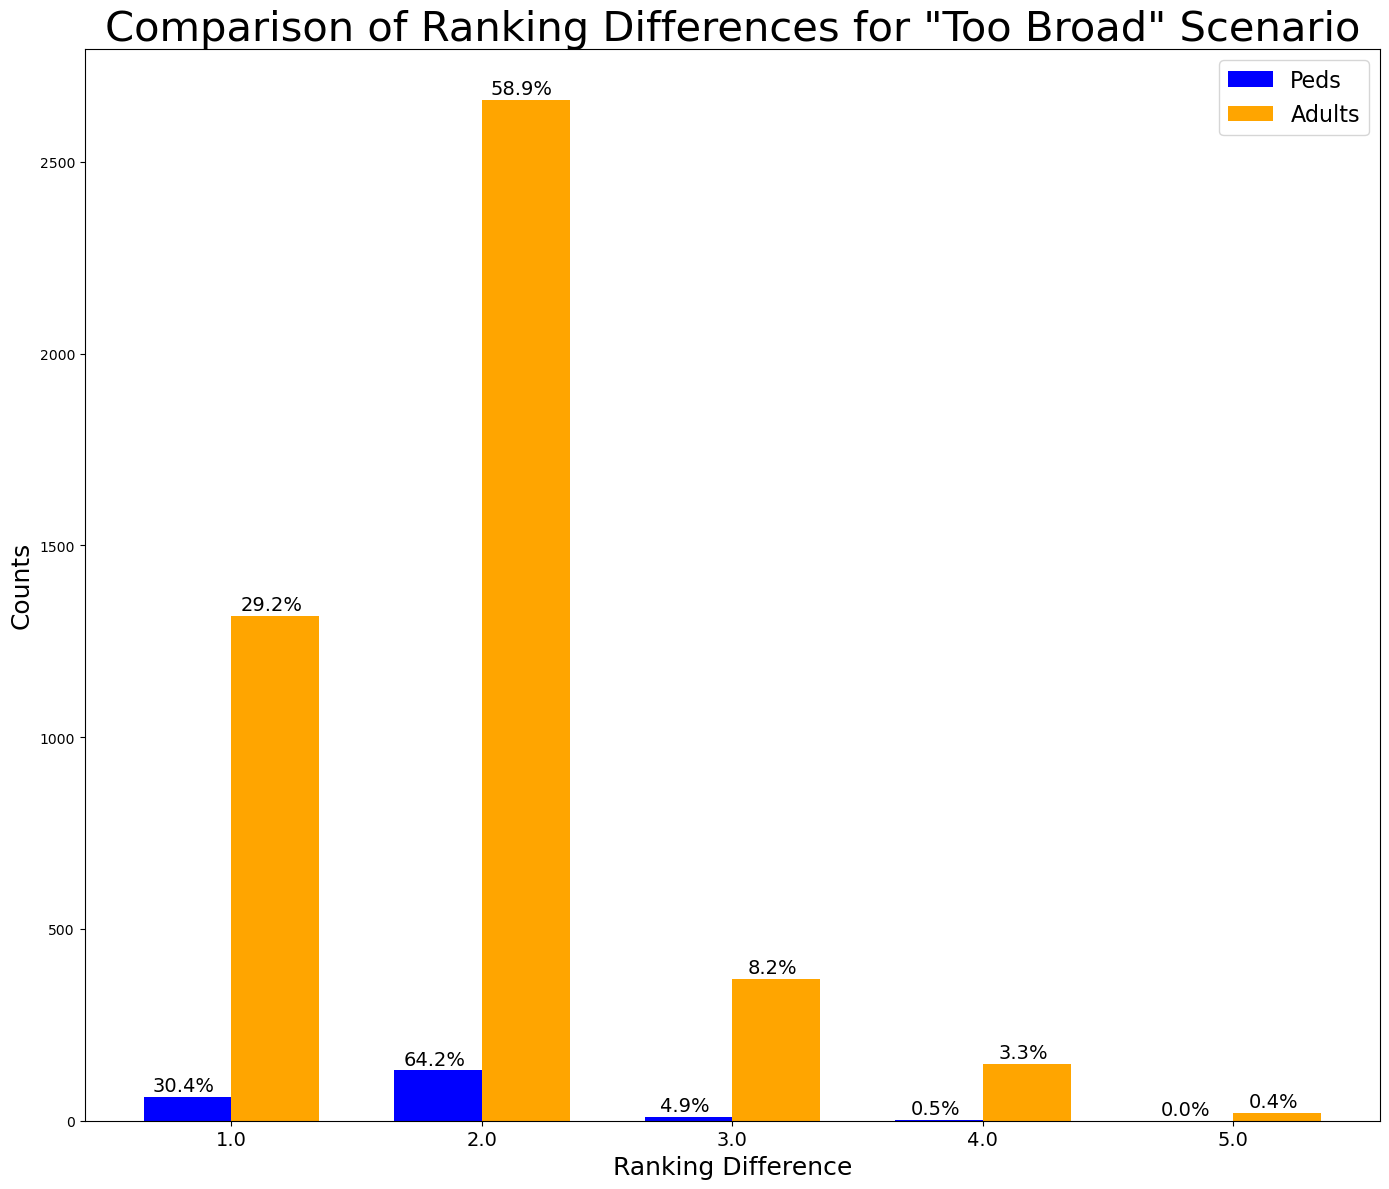

In [193]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your two CSV files
# df1 = pd.read_csv('file1.csv')  # Replace with your first file
# df2 = pd.read_csv('file2.csv')  # Replace with your second file

plt.figure(figsize=(14, 12))

# Filter for "too_broad" scenario and get ranking_diff counts for both datasets
ranking_diff_counts1 = df1[df1["scenario"] == "too_broad"]["ranking_diff"].value_counts().sort_index()
ranking_diff_counts2 = df2[df2["scenario"] == "too_broad"]["ranking_diff"].value_counts().sort_index()

# Calculate percentages
ranking_diff_percentages1 = (ranking_diff_counts1 / ranking_diff_counts1.sum()) * 100
ranking_diff_percentages2 = (ranking_diff_counts2 / ranking_diff_counts2.sum()) * 100

# Ensure both datasets have the same ranking_diff values (fill missing with 0)
all_ranking_diffs = sorted(set(ranking_diff_counts1.index).union(set(ranking_diff_counts2.index)))
ranking_diff_counts1 = ranking_diff_counts1.reindex(all_ranking_diffs, fill_value=0)
ranking_diff_counts2 = ranking_diff_counts2.reindex(all_ranking_diffs, fill_value=0)
ranking_diff_percentages1 = ranking_diff_percentages1.reindex(all_ranking_diffs, fill_value=0)
ranking_diff_percentages2 = ranking_diff_percentages2.reindex(all_ranking_diffs, fill_value=0)

# Set up the plot
ax = plt.gca()
bar_width = 0.35

# Set positions for the bars
r1 = range(len(all_ranking_diffs))
r2 = [x + bar_width for x in r1]

# Plot bars for both datasets
bars1 = ax.bar(r1, ranking_diff_counts1, width=bar_width, color='blue', label='Peds')
bars2 = ax.bar(r2, ranking_diff_counts2, width=bar_width, color = 'orange', label='Adults')

# Add percentages on top of the bars
for i, (count1, count2, pct1, pct2) in enumerate(zip(ranking_diff_counts1, ranking_diff_counts2, 
                                                      ranking_diff_percentages1, ranking_diff_percentages2)):
    ax.text(i - bar_width/2 +0.16, count1 + 5, f'{pct1:.1f}%', ha='center', va='bottom', fontsize=14)
    ax.text(i + bar_width/2 + 0.16, count2 + 5, f'{pct2:.1f}%', ha='center', va='bottom', fontsize=14)

# Customize the plot
ax.set_title('Comparison of Ranking Differences for "Too Broad" Scenario', fontsize=30)
ax.set_xlabel("Ranking Difference", fontsize=18)
ax.set_ylabel("Counts", fontsize=18)
ax.set_xticks([r + bar_width/2 for r in range(len(all_ranking_diffs))])
ax.set_xticklabels(all_ranking_diffs, fontsize=14)
ax.legend(fontsize=16)

plt.tight_layout()
plt.show()